In [ ]:
# Authors:
#     Shane Takeuchi
#     Michael Chovanak

In [3]:
using Pkg
Pkg.add("LinearAlgebra");
Pkg.add("CSV");
Pkg.add("LightGraphs");
Pkg.add("GraphPlot");
Pkg.add("SimpleWeightedGraphs");
Pkg.add("Plots");

   Updating registry at `~/.julia/registries/General`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


In [4]:
using LinearAlgebra
using CSV
using LightGraphs
using GraphPlot
using SimpleWeightedGraphs
using Statistics
using Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


In [5]:
println("Running Entire Song Recommendation Tester")

Running Entire Song Recommendation Tester


In [6]:
# Read in the Data
allData = CSV.read("data.csv");

# Functions For Playlist Creation

In [7]:
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# FUNCTIONS TO BUILD PLAYLIST
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

###################################################################################################
# Procedure:
#     readSongFile
# Parameters:
#     filename -  a file name in the current directory containing songs with artists
# Purpose:
#     A simple regex to get songs and artists to quickly build large playlist.
#     Because we don't have a direct link to Spotify we use this. We can copy and past a playlist into a text document from
#         Spotify and each line is in the general format "songTitle - artistName". We then convert this into a list of simplified
#         song title, artist pairs that we can search for in our dataset.
#     Only returns a single artist for simplification purposes
# Produces:
#     Returns a list of song, artist pairs
# Preconditions
#     filename - a string of a filename in your current working directory with song artist pairs in the format "song - artist"
# Postconditions
#     Returns a list of pairs
#         song title(string)
#         artist name(string)
function readSongFile(filename)
    songReg = r"(?<song>.*)(\s–\s)(?<artist>.*)"
    artistReg = r"(?<artist>.*?)(,|\z)"
    playlist = []
    f = open(filename, "r")
    for line in readlines(f) 
        songMatch = match(songReg, line)
        aritstMatch = match(artistReg, songMatch[:artist])

        push!(playlist, (songMatch[:song], aritstMatch[:artist]))
    end
    close(f)

    return playlist
end


###################################################################################################
# Procedure:
#     readSongFile_WithoutFeat
# Parameters:
#     filename -  a file name in the current directory containing songs with artists
# Purpose:
#     A simple regex to get songs and artists to quickly build large playlist.
#     Because we don't have a direct link to Spotify we use this. We can copy and past a playlist into a text document from
#         Spotify and each line is in the general format "songTitle - artistName". We then convert this into a list of simplified
#         song title, artist pairs that we can search for in our dataset.
#     Only returns a single artist for simplification purposes
#     Excludes specific parts of song titles for simplification
# Produces:
#     Returns a list of song, artist pairs
# Preconditions
#     filename - a string of a filename in your current working directory with song artist pairs in the format "song - artist"
# Postconditions
#     Returns a list of pairs
#         song title(string)
#         artist name(string)
function readSongFile_WithoutFeat(filename)
    splitReg = r"(?<song>.*)(\s–\s)(?<artist>.*)"
    songReg = r"(?<song>.*?)(\s\(feat.*|\z)"
    artistReg = r"(?<artist>.*?)(,|\z)"
    playlist = []
    f = open(filename, "r")
    for line in readlines(f) 
        splitMatch = match(splitReg, line)
        aritstMatch = match(artistReg, splitMatch[:artist])
        songMatch = match(songReg, splitMatch[:song])

        push!(playlist, (songMatch[:song], aritstMatch[:artist]))
    end
    close(f)

    return playlist
end


###################################################################################################
# Procedure:
#     getSongID
# Parameters:
#     dataset - the dataset of songs and their attributes
#     songNameArtistPair - a pair including song title and artist
# Purpose:
#     Retreive the song Id from the dataset for single song
# Produces:
#     Returns a song Id corresponding to the first matching song and artist in the dataset
# Preconditions
#     dataset - a data frame with columns of song attributes and each row represenst an individual song
#     songNameArtistPair - a pair
#         song title(string)
#         artist(string)
# Postconditions
#     Returns a string
function getSongID(dataset, songNameArtistPair)
    for i in 1:size(dataset)[1]
        song = dataset[i,:]
        if occursin(lowercase(songNameArtistPair[1]), lowercase(song[13])) && occursin(lowercase(songNameArtistPair[2]), lowercase(song[2]))
            return song[7]
        end
    end
    println("Could not find ", songNameArtistPair[1], " by ", songNameArtistPair[2])
    return "null"
end


###################################################################################################
# Procedure:
#     getPlaylist
# Parameters:
#     dataset - the dataset of songs and their attributes
#     songNameArtistPairs - a list of pairs including song title and artist
# Purpose:
#     Retreive song Ids from the dataset for multiple songs
# Produces:
#     Returns a list of song Ids corresponding to the matching songs and artists in the dataset
# Preconditions
#     dataset - a data frame with columns of song attributes and each row represenst an individual song
#     songNameArtistPairs - a list of pairs
#         song title(string)
#         artist(string)
# Postconditions
#     Returns a list of strings
function getPlaylist(dataset, songNameArtistPairs)
    IDs = []
    for pair in songNameArtistPairs
        ID = getSongID(dataset, pair)
        if(ID != "null")
            push!(IDs, ID)
        end
    end
    return IDs
end

getPlaylist (generic function with 1 method)

# Playlists

In [8]:
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Build Playlists
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [9]:
# List of songs from Spotify's "90s Rock Anthems" Playlist(10/20/2020)
# Note: Not all of these songs are in the dataset that we used. Commented out songs are not contained in the dataset.
println("Building \"90's Rock Anthems\" Playlists")
rockAnthems = [
    ("Smells Like Teen Spirit", "Nirvana")
    ("Jeremy", "Pearl Jam")
    ("Killing In The Name", "Rage Against The Machine")
    ("Under the Bridge", "Red Hot Chili Peppers")
    ("Zombie", "The Cranberries")
    ("Black Hole Sun", "Soundgarden")
    ("High And Dry", "Radiohead")
    ("1979 - Remastered 2012", "The Smashing Pumpkins")
    ("Closer", "Nine Inch Nails")
    ("No Excuses", "Alice In Chains")
    ("Enter Sandman", "Metallica")
    ("Wonderwall - Remastered", "Oasis")
    ("November Rain", "Guns N' Roses")
    ("Longview", "Green Day")
    ("Plush", "Stone Temple Pilots")
    ("Been Caught Stealing", "Jane's Addiction")
    ("Bitter Sweet Symphony", "The Verve")
    ("Hunger Strike - 25th Anniversary Mix", "Temple Of The Dog")
    ("Song 2 - 2012 Remaster", "Blur")
    ("What I Got", "Sublime")
    ("Celebrity Skin", "Hole")
    ("Losing My Religion", "R.E.M.")
    ("Loser", "Beck")
    ("Machinehead", "Bush")
    ("Cryin'", "Aerosmith")
    ("Drive", "Incubus")
    ("Don't Speak", "No Doubt")
    ("All The Small Things", "blink-182")
    ("Hard To Handle", "The Black Crowes")
    ("You Oughta Know", "Alanis Morissette")
    ("One", "U2")
    ("Don't Look Back In Anger - Remastered", "Oasis")
    ("Lightning Crashes", "Live")
    ("Take a Picture", "Filter")
    ("Karma Police", "Radiohead")
    ("Come As You Are", "Nirvana")
    ("Give It Away", "Red Hot Chili Peppers")
    ("Wicked Garden", "Stone Temple Pilots")
    ("Epic", "Faith No More")
    ("Chloe Dancer/Crown Of Thorns", "Mother Love Bone")
    ("Say It Ain't So", "Weezer")
    ("Today - Remastered", "The Smashing Pumpkins")
    ("Sabotage", "Beastie Boys")
    ("Sugar", "System Of A Down")
    ("Bulls On Parade", "Rage Against The Machine")
    ("Stop", "Jane's Addiction")
    ("Cannonball", "The Breeders")
    ("Live And Let Die", "Guns N' Roses")
    ("When I Come Around", "Green Day")
    ("Nearly Lost You", "Screaming Trees")
    ("Live Forever - Remastered", "Oasis")
    ("Backwater", "Meat Puppets")
    ("No Rain", "Blind Melon")
    ("Tomorrow", "Silverchair")
    ("Down", "311")
    ("Low", "Cracker")
    ("She Don't Use Jelly", "The Flaming Lips")
    ("Possum Kingdom", "Toadies")
    ("What's My Age Again?", "blink-182")
    ("Flagpole Sitta", "Harvey Danger")
    ("Just A Girl", "No Doubt")
    ("Semi-Charmed Life", "Third Eye Blind")
    ("Are You Gonna Go My Way", "Lenny Kravitz")
    ("Personal Jesus - Original Single Version", "Depeche Mode")
    ("Lump", "The Presidents Of The United States Of America")
    ("Laid", "James")
    ("Cherub Rock - Remastered 2011", "The Smashing Pumpkins")
    ("Creep", "Radiohead")
    ("Sell Out", "Reel Big Fish")
    ("Tonight, Tonight - Remastered 2012", "The Smashing Pumpkins")
    ("Good", "Better Than Ezra")
    ("Santeria", "Sublime")
    ("Everything About You", "Ugly Kid Joe")
    ("Touch, Peel And Stand", "Days Of The New")
    ("Self Esteem", "The Offspring")
    ("Even Flow", "Pearl Jam")
    ("Would?", "Alice In Chains")
    ("Bound For The Floor", "Local H")
    ("Seether", "Veruca Salt")
    ("Plowed", "Sponge")
    ("Cumbersome", "Seven Mary Three")
    ("Sister", "The Nixons")
    ("I Got A Girl", "Tripping Daisy")
    ("Santa Monica", "Everclear")
    ("Fell On Black Days", "Soundgarden")
    ("About A Girl", "Nirvana")
    ("Daughter (Remastered)", "Pearl Jam")
    ("Disarm - Remastered", "The Smashing Pumpkins")
    ("Got You (Where I Want You)", "The Flys")
    ("Come Out and Play", "The Offspring")
    ("Not Enough Time", "INXS")
    ("Jerry Was A Race Car Driver", "Primus")
    ("Unsung", "Helmet")
    ("Sex Type Thing", "Stone Temple Pilots")
    ("Breaking the Girl", "Red Hot Chili Peppers")
    ("Molly (16 Candles)", "Sponge")
    ("You", "Candlebox")
    ("Shine", "Collective Soul")
    ("Shimmer", "Fuel")
    ("Pepper", "Butthole Surfers")
#     ("Feel The Pain - 2007 Remastered", "Dinosaur Jr.")
    ("Pets", "Porno for Pyros")
    ("Into Your Arms", "The Lemonheads")
    ("In the Meantime", "Spacehog")
    ("Dizz Knee Land", "Dada")
    ("My Own Worst Enemy", "Lit")
    ("Save Yourself", "Stabbing Westward")
    ("This Is a Call", "Foo Fighters")
    ("Better Days (And the Bottom Drops Out)", "Citizen King")
    ("State of Love and Trust", "Pearl Jam")
    ("Stupid Girl", "Garbage")
    ("Runaway Train", "Soul Asylum")
    ("Standing Outside a Broken Phone Booth with Money in My Hand", "Primitive Radio Gods")
    ("Change - 2002 Digital Remaster", "Blind Melon")
    ("The Distance", "Cake")
    ("River Of Deceit", "Mad Season")
    ("Doll Parts", "Hole")
    ("Mother Mother", "Tracy Bonham")
    ("Naked Eye", "Luscious Jackson")
    ("Dammit", "blink-182")
    ("Welcome to Paradise", "Green Day")
    ("Heart-Shaped Box", "Nirvana")
    ("Hurt", "Nine Inch Nails")
    ("Nutshell", "Alice In Chains")
#     ("Hey Man, Nice Shot - Remastered Version", "Filter")
    ("Nothing Else Matters", "Metallica")
    ("Everlong", "Foo Fighters")
    ("The Impression That I Get", "The Mighty Mighty Bosstones")
    ("Man in the Box", "Alice In Chains")
    ("High", "The Cure")
    ("Spoonman", "Soundgarden")
    ("All Mixed Up", "311")
    ("Superman", "Goldfinger")
    ("Novocaine For The Soul", "Eels")
    ("Suck You Dry - 2008 Remaster", "Mudhoney")
    ("Alive", "Pearl Jam")
    ("Freak", "Silverchair")
    ("Everything Zen", "Bush")
    ("Rearviewmirror", "Pearl Jam")
    ("Disarm", "The Smashing Pumpkins")
    ("Serve The Servants", "Nirvana")
    ("Far Behind", "Candlebox")
    ("Bullet With Butterfly Wings", "The Smashing Pumpkins")
    ("Go", "Pearl Jam")
    ("Where Did You Sleep Last Night", "Nirvana")
    ("Say Hello 2 Heaven", "Temple Of The Dog")
    ("Heaven Beside You", "Alice In Chains")
    ("Sugar Kane", "Sonic Youth")
    ("Little Things", "Bush")
    ("Crazy", "Aerosmith")
    ("Interstate Love Song", "Stone Temple Pilots")
    ("Stars", "Hum")
];
rockAnthemsIds = getPlaylist(allData, rockAnthems);

Building "90's Rock Anthems" Playlists


In [10]:
# List of songs recommended by Spotify for a playlist of the songs from Spotify's "90s Rock Anthems" Playlist(10/20/2020)
# Note: These song recommendations are based on the entirety of the "90s Rock Anthems" playlist even though out dataset does not have all the songs
rockAnthemsRec = [
    ("Hunger Strike", "Temple Of The Dog")
    ("Popular", "Nada Surf")
    ("Counting Blue Cars (Tell Me Your Thoughts On God)", "Dishwalla")
    ("Sex & Candy", "Marcy Playground")
    ("Hey Jealousy", "Gin Blossoms")
    ("I Alone", "Live")
    ("Sucked Out", "Superdrag")
    ("Vasoline - 2019 Remaster", "Stone Temple Pilots")
    ("Here and Now", "Letters To Cleo")
    ("Inside Out", "Eve 6")
    ("If You Could Only See", "Tonic")
    ("Jane Says", "Jane's Addiction")
    ("One Headlight", "The Wallflowers")
    ("Banditos", "The Refreshments")
    ("Connection", "Elastica")
    ("Volcano Girls", "Veruca Salt")
    ("Desperately Wanting", "Better Than Ezra")
    ("The Way", "Fastball")
    ("Outshined", "Soundgarden")
    ("Super Bon Bon", "Soul Coughing")
    ("All Over You", "Live")
    ("Only Happy When It Rains", "Garbage")
    ("Big Empty - 2019 Remaster", "Stone Temple Pilots")
    ("Found Out About You", "Gin Blossoms")
    ("Rooster", "Alice In Chains")
    ("Fall Down", "Toad The Wet Sprocket")
    ("Girlfriend", "Matthew Sweet")
    ("Feed the Tree", "Belly")
    ("Pretend We're Dead", "L7")
    ("Here In Your Bedroom", "Goldfinger")
    ("Little Black Backpack (Remastered)", "Stroke 9")
    ("Everything Falls Apart", "Dog's Eye View")
    ("Violet", "Hole")
    ("Closing Time", "Semisonic")
    ("The World I Know", "Collective Soul")
    ("Why I'm Here", "Oleander")
    ("Til I Hear It From You", "Gin Blossoms")
    ("Mmm Mmm Mmm Mmm", "Crash Test Dummies")
    ("Undone - The Sweater Song", "Weezer")
    ("Somebody to Shove", "Soul Asylum")
];
rockAnthemsRecIds = getPlaylist(allData, rockAnthemsRec);

In [11]:
# List of songs from Spotify's "Classical Essentials" Playlist(10/20/2020)
# Note: Not all of these songs are in the dataset that we used. Commented out songs are not contained in the dataset.
println("Building \"Classical Essentials\" Playlists")
classicalEssentials = [
#     ("The Well-Tempered Clavier: Book 1, BWV 846-869: 1. Prelude in C Major, BWV 846", "Johann Sebastian Bach")
    ("The Lark Ascending", "Ralph Vaughan Williams")
    ("Handel / Orch. Hale: Keyboard Suite in D Minor, HWV 437: III. Sarabande", "George Frideric Handel")
#     ("Bagatelle No. 25 in A Minor, \"Für Elise\", WoO 59", "Ludwig van Beethoven")
    ("Rhapsody On A Theme Of Paganini, Op.43: Variation 18. Andante cantabile", "Sergei Rachmaninoff")
    ("Cello Concerto in E Minor, Op.85 (1988 Digital Remaster): I. Adagio - Moderato", "Edward Elgar")
    ("Rhapsody In Blue", "George Gershwin")
    ("Cello Suite No. 1 in G Major, BWV 1007: I. Prélude", "Johann Sebastian Bach")
    ("Meditation: Méditation from Thaïs", "Jules Massenet")
    ("Gnossienne No. 1", "Erik Satie")
    ("Piano Concerto in A Minor, Op.16: I. Allegro molto moderato", "Edvard Grieg")
    ("Suite bergamasque, L. 75: 3. Clair de lune", "Claude Debussy")
#     ("Danse Macabre, Op.40, R.171", "Camille Saint-Saëns")
    ("Symphony No. 40 in G Minor, K. 550: I. Molto allegro", "Wolfgang Amadeus Mozart")
    ("Mahler: Symphony No. 5 in C-Sharp Minor: IV. Adagietto", "Gustav Mahler")
    ("Chopin: Nocturne No. 20 in C-Sharp Minor, Op. Posth.", "Frédéric Chopin")
    ("Parce Mihi Domine", "Jan Garbarek")
#     ("Piano Concerto No.3 in C, Op.26: 1. Andante - Allegro", "Sergei Prokofiev")
    ("An der schönen blauen Donau, Op.314", "Johann Strauss II")
#     ("Pachelbel: Canon and Gigue in D Major for 3 Violins and Continuo, P. 37: I. Canon (Orchestral Version)", "Johann Pachelbel")
    ("Piano Concerto No. 2 in C Minor, Op. 18: 2. Adagio sostenuto", "Sergei Rachmaninoff")
    ("Mozart: Clarinet Concerto in A Major, K. 622: II. Adagio", "Wolfgang Amadeus Mozart")
    ("Symphony No. 5 in C Minor, Op. 67: I. Allegro con brio", "Ludwig van Beethoven")
#     ("Rodrigo: Concierto de Aranjuez: II. Adagio", "Joaquín Rodrigo")
    ("Hummel: Trumpet Concerto In E Flat - Iii Rondo", "Johann Nepomuk Hummel")
    ("Ravel: Pavane pour une infante défunte, M. 19", "Maurice Ravel")
    ("The Carnival of the Animals, R. 125: XIII. The Swan (Arr. for Cello and Piano)", "Camille Saint-Saëns")
    ("Turandot / Act 3: \"Nessun dorma!\"", "Giacomo Puccini")
    ("The Sorcerer's Apprentice", "Paul Dukas")
    ("Fanfare for the Common Man", "Aaron Copland")
    ("Piano Concerto in A Minor, Op. 16: I. Allegro molto moderato", "Edvard Grieg")
    ("Suite No.3 In D, BWV 1068: 2. Air", "Johann Sebastian Bach")
    ("Symphony No.8 in B minor, D.759 - \"Unfinished\": 1. Allegro moderato", "Franz Schubert")
#     ("Piano Concerto No. 1 in B-Flat Minor, Op. 23: I. Allegro non troppo e molto maestoso – Allegro con spirito", "Pyotr Ilyich Tchaikovsky")
    ("Piano Sonata No. 14 in C-Sharp Minor, Op. 27 No. 2 \"Moonlight\": I. Adagio sostenuto", "Ludwig van Beethoven")
#     ("Overture Candide", "Leonard Bernstein")
    ("Andante festivo for Strings and Timpani, JS 34b", "Jean Sibelius")
    ("Liebestraum No. 3 in A-Flat Major, S. 541 / 3", "Franz Liszt")
    ("O Magnum Mysterium: O magnum mysterium", "Morten Lauridsen")
    ("Scheherazade: The Tale of the Kalendar Prince", "Nikolai Rimsky-Korsakov")
    ("Barber: Adagio for Strings", "Samuel Barber")
#     ("Goldberg Variations, BWV 988: Variatio 7 a 1 ovvero 2 Clav. Al tempo di Giga", "Johann Sebastian Bach")
    ("Prince Igor (Knyaz Igor): Act II: Polovtsian Dances - Ulyetay na kril'yahk vyetra (Fly away on the wings of the wind) (version for chorus)", "Alexander Borodin")
    ("Requiem in D minor, K.626: 3. Sequentia: Confutatis", "Wolfgang Amadeus Mozart")
    ("Prokofiev: Romeo and Juliet, Op. 64, Act 1: No. 13, Dance of the Knights (Complete Ballet)", "Sergei Prokofiev")
    ("Different Trains: America, Before the War", "Steve Reich")
    ("Violin Sonata in A Major, FWV 8: IV. Allegretto poco mosso", "César Franck")
    ("Adiemus", "Karl Jenkins")
    ("Khachaturian: Spartacus Suite No. 2: I. Adagio of Spartacus and Phrygia", "Aram Khachaturian")
    ("Spiegel im Spiegel - Version for Violin and Piano", "Arvo Pärt")
    ("Recomposed By Max Richter: Vivaldi, The Four Seasons: Spring 1", "Max Richter")
#     ("Elégie in C Minor, Op. 24 (Arr. Parkin)", "Gabriel Fauré")
#     ("Sechs Klavierstücke, Op. 118: II. Intermezzo in A Major", "Johannes Brahms")
    ("Ständchen in D Minor (After Schubert), S. 560", "Franz Liszt")
    ("Serenade in B-Flat Major, K. 361 \"Gran Partita\": 3. Adagio", "Wolfgang Amadeus Mozart")
    ("Il barbiere di Siviglia: Overture (Sinfonia)", "Gioachino Rossini")
    ("Peer Gynt, Op. 23: Act II, 7, In the Hall of the Mountain King", "Edvard Grieg")
    ("Paganini: 24 Caprices, Op. 1: No. 24 in A Minor (Tema con variazioni. Quasi presto)", "Niccolò Paganini")
#     ("Dolly, Op.56: 1. Berceuse", "Gabriel Fauré")
    ("Theme From Jurassic Park", "John Williams")
    ("Tsar Saltan, Op. 57: Flight of the Bumblebee", "André Previn")
    ("Symphonic Variations on an African Air, Op.63", "Samuel Coleridge-Taylor")
#     ("The Rite of Spring: Part One: Adoration of the Earth: Introduction", "Igor Stravinsky")
    ("Symphony No. 3 in C Minor, Op. 78 \"Organ Symphony\": 2b. Maestoso - Più allegro - Molto allegro", "Camille Saint-Saëns")
#     ("String Sextet in D Minor, Op. 70, \"Souvenir de Florence\": I. Allegro con spirito", "Pyotr Ilyich Tchaikovsky")
    ("Rêverie, L. 68: Rêverie", "Claude Debussy")
    ("Theme From Schindler's List", "John Williams")
    ("The Four Seasons - Violin Concerto in F Minor, Op. 8 No. 4, RV 297 \"Winter\": I. Allegro non molto", "Antonio Vivaldi")
    ("Young Person's Guide To The Orchestra", "Benjamin Britten")
    ("Sonata for 2 pianos in D, K.448: 1. Allegro con spirito", "Wolfgang Amadeus Mozart")
    ("The Gadfly Suite, Op. 97a: VIII. Romance", "Dmitri Shostakovich")
#     ("Piano Concerto in C-Sharp Minor, FP 146: I. Allegretto commodo - Live", "Francis Poulenc")
    ("Serenade for Strings in C major, Op. 48: II. Walzer: Moderato, tempo di valse", "Pyotr Ilyich Tchaikovsky")
#     ("Pelléas et Mélisande, Op. 80: 4. Sicilienne", "Gabriel Fauré")
    ("Goldberg Variations, BWV 988: Aria da capo - 1981 Version", "Johann Sebastian Bach")
    ("On The Nature Of Daylight", "Max Richter")
    ("Ave Maria, D. 839", "Franz Schubert")
#     ("Symphony No.3 in F, Op.90: 1. Allegro con brio - Un poco sostenuto - Tempo I", "Johannes Brahms")
    ("Sibelius : Finlandia Op.26", "Jean Sibelius")
#     ("Piazzolla: Libertango", "Alison Balsom")
    ("Mephisto Waltz No. 1, S. 514", "Franz Liszt")
#     ("Merry Christmas Mr. Lawrence (Arr. Metcalfe)", "Jess Gillam")
    ("Hungarian Dance No.5 in G Minor, WoO 1, No.5", "Johannes Brahms")
#     ("Piano Concerto No. 5 in E-Flat Major, Op. 73 \"Emperor\": 2. Adagio un poco mosso - Live at Konzerthaus Berlin / 2018", "Ludwig van Beethoven")
#     ("Symphony No.5 in E flat, Op.82: 3. Allegro molto", "Jean Sibelius")
    ("Pini di Roma (The Pines of Rome): III. I pini del Gianiclo", "Ottorino Respighi")
    ("Cello Concerto No.1, Op.107: 1. Allegretto", "Dmitri Shostakovich")
#     ("Schumann: Widmung, Op. 25 No. 1 (Arr. Liszt, S. 566a)", "Robert Schumann")
#     ("Pictures At An Exhibition: The Hut On Fowl's Legs (Baba-Yaga)", "Modest Mussorgsky")
#     ("Ravel: Miroirs, M. 43: IV. Alborada del gracioso", "Maurice Ravel")
    ("Hedwig's Theme", "John Williams")
#     ("Carmina Burana: I. O Fortuna", "Carl Orff")
    ("Delius: 2 Pieces for Small Orchestra: No. 1, On Hearing the First Cuckoo in Spring", "Frederick Delius")
    ("St. Matthew Passion, BWV 244 / Part Two: \"Erbarme dich\"", "Johann Sebastian Bach")
    ("Appalachian Spring: VII. Doppio movimento", "Aaron Copland")
#     ("Now Sleeps The Crimson Petal (Four Madrigals On Rose Texts): Now Sleeps The Crimson Petal", "Paul Mealor")
    ("Symphony No. 9 in E Minor, Op. 95 \"From the New World\": II. Largo - Live", "Antonín Dvořák")
    ("Carmen, Act I: No.5 Habanera : L'amour est un oiseau rebelle (Carmen/Cigarières/Jeunes gens/Dragons)", "Georges Bizet")
#     ("Violin Concerto No.1 in G minor, Op.26: 1. Vorspiel (Allegro moderato)", "Max Bruch")
    ("Largo al factotum", "Gioachino Rossini")
    ("Cello Concerto In B Minor, Op.104, B. 191: 1. Allegro", "Antonín Dvořák")
    ("Nocturne No. 2 in E-Flat Major, Op. 9 No. 2", "Frédéric Chopin")
    ("An American in Paris", "George Gershwin")
#     ("Speaking Unto Nations (Beethoven Symphony no 7 - II )", "Ludwig van Beethoven")
#     ("Trumpet Concerto in D Major, TWV 51:D7: I. Adagio", "Georg Philipp Telemann")
#     ("Cavatina (From \"The Deer Hunter\")", "Stanley Myers")
#     ("Rhapsodie Orientale, Op.29: 1. Andante", "Alexander Glazunov")
#     ("Variations on a Rococo Theme, Op. 33 for cello and orchestra: Var. VI: Andante", "Pyotr Ilyich Tchaikovsky")
#     ("Ombra Mai Fu", "Malena Ernman")
#     ("St. Paul's Suite : 3. Intermezzo: Andante con moto", "Gustav Holst")
#     ("Violin Concerto In E Minor, Op.64, MWV O14: 1. Allegro molto appassionato", "Felix Mendelssohn")
    ("The Godfather: V. Love Theme", "Nino Rota")
    ("The Nutcracker, Op.71, TH.14 / Act 2: No. 12b Coffee (Arabian Dance)", "Pyotr Ilyich Tchaikovsky")
#     ("Nimrod (Lux Aeterna)", "Edward Elgar")
    ("Serenade for Strings in E Major, Op. 22, B. 52: II. Tempo di valse", "Antonín Dvořák")
#     ("Symphony No. 6 in F Major, Op. 68 \"Pastoral\": I. Awakening of Cheerful Feelings Upon Arrival in the Country: Allegro ma non troppo", "Ludwig van Beethoven")
#     ("Concerto in F: 3. Allegro agitato", "George Gershwin")
    ("Orfeo Ed Euridice: Dance Of The Blessed Spirits (Act 2)", "Christoph Willibald Gluck")
    ("Comptine d'un autre été, l'après-midi", "Yann Tiersen")
#     ("Trois chansons, M.69: 2. Trois beaux oiseaux du Paradis", "Maurice Ravel")
#     ("Organ Sonata No. 4, BWV 528: 2. Andante [Adagio] (Transcr. by August Stradal)", "Johann Sebastian Bach")
    ("Jazz Suite No.2: 4. Waltz I", "Dmitri Shostakovich")
    ("Solomon HWV 67 / Act 3: The Arrival Of The Queen Of Sheba", "George Frideric Handel")
    ("4 Impromptus, Op.90, D.899: No.4 in A Flat Major: Allegretto", "Franz Schubert")
#     ("String Quartet: I. Modere", "Germaine Tailleferre")
#     ("Symphonie fantastique, Op. 14: Symphonie fantastique, Op. 14: IV. Marche au supplice", "Hector Berlioz")
    ("The Hebrides, Op.26 (Fingal's Cave)", "Felix Mendelssohn")
    ("Etude No. 2", "Philip Glass")
#     ("Die Zauberflöte, K.620 : Der Hölle Rache...Morden soll ich?", "Wolfgang Amadeus Mozart")
#     ("Symphony No. 104 in D Major, Hob.I:104 \"London\": 4. Finale (Spiritoso) - Live", "Franz Joseph Haydn")
#     ("Prelude & Fughetta in G Major, BWV 902: 1. Prelude", "Johann Sebastian Bach")
#     ("3 Pieces for cello and piano: No. 1. Modere", "Nadia Boulanger")
    ("Symphony No.25 in G minor, K.183: 1. Allegro con brio", "Wolfgang Amadeus Mozart")
#     ("Messiah, HWV 56, Pt. 2 Scene 7: No. 44, Hallelujah (Chorus)", "George Frideric Handel")
#     ("Nonet in E-Flat Major, Op. 38: III. Scherzo: Vivace", "Louise Farrenc")
    ("Kinderszenen, Op. 15: VII. Träumerei", "Robert Schumann")
#     ("Violin Concerto In D Major, Op.35: 3. Finale: Allegro assai vivace", "Erich Wolfgang Korngold")
#     ("Just (After Song of Songs)", "David Lang")
    ("Violin Concerto BWV 1042 in E Major: Violin Concerto BWV 1042 in E Major: I. Allegro", "Johann Sebastian Bach")
#     ("The Lamb", "John Tavener")
    ("3 Gymnopédies: No.1 Lent et douloureux", "Erik Satie")
    ("Prélude à l'après-midi d'un faune, L.86", "Claude Debussy")
#     ("Finding the Pattern", "Jessica Curry")
    ("String Quartet No. 62 in C Major, Op. 76, No. 3, Hob.III:77, \"Emperor\": II. Poco adagio, cantabile", "Franz Joseph Haydn")
#     ("Les Baricades Mistérieuses (6e ordre)", "François Couperin")
    ("The Promise", "Michael Nyman")
    ("Adagio For Strings And Organ In G Minor", "Tomaso Albinoni")
#     ("Symphony No. 4 in E-Flat Major, WAB 104, \"Romantic\": I. Bewegt, nicht zu schnell - Live", "Anton Bruckner")
    ("Rigoletto / Act 3: \"La donna è mobile\"", "Giuseppe Verdi")
    ("Tchaikovsky : 1812 Overture Op.49", "Pyotr Ilyich Tchaikovsky")
#     ("Saxophone Concerto, Op. 59, \"Cyber-bird\": I. Bird in Colors: Allegro", "Takashi Yoshimatsu")
    ("Nocturne No.1 in B flat minor, Op.9 No.1", "Frédéric Chopin")
#     ("Kol Nidrei - Adagio For Cello, Opus 47", "Max Bruch")
    ("Time", "Hans Zimmer")
    ("Young Birches, Op. 128, No. 2", "Amy Beach")
#     ("Amor dormiglione", "Barbara Strozzi")
#     ("Vaughan Williams: Job, Scene 9: Epilogue", "Ralph Vaughan Williams")
#     ("String Quartet No. 1 'Kreutzer Sonata': String Quartet No. 1 'Kreutzer Sonata': I. Adagio. Con moto", "Leoš Janáček")
    ("Tchaikovsky: The Nutcracker - Ballet, Op. 71, Act 1: No. 2 March", "Pyotr Ilyich Tchaikovsky")
#     ("Scottish Fantasy for Violin and Orchestra, Op. 46: I. Introduction: Grave, Adagio cantabile", "Max Bruch")
    ("Tahiti Trot, Op. 16 (After V. Youmans's \"Tea for Two\")", "Dmitri Shostakovich")
    ("Concerto For 2 Mandolins, Strings And Continuo In G, RV 532: 3. Allegro", "Antonio Vivaldi")
#     ("L'Orfeo - Prologo: Toccata", "Claudio Monteverdi")
    ("Songs from \"Friday Afternoons\", Op.7: Songs From Friday Afternoons, Op. 7: \"Cuckoo!\"", "Benjamin Britten")
    ("The Firebird (L'oiseau De Feu) - Suite (1919): Finale", "Igor Stravinsky")
    ("Holberg Suite, Op. 40: 1. Präludium (Allegro vivace)", "Edvard Grieg")
#     ("Die Forelle, Op. 32, D. 550", "Franz Schubert")
    ("Cello Concerto No. 1 in C Major, Hob.VIIb:1: III. Allegro molto", "Franz Joseph Haydn")
    ("Lohengrin: Prelude", "Richard Wagner")
];
classicalEssentialsIds = getPlaylist(allData, classicalEssentials);

Building "Classical Essentials" Playlists


In [12]:
# List of songs recommended by Spotify for a playlist of the songs from Spotify's "Classical Essentials" Playlist(10/20/2020)
# Note: Not all of these songs are in the dataset that we used. Commented out songs are not contained in the dataset.
# Note: These song recommendations are based on the entirety of the "Classical Essentials" playlist even though out dataset does not have all the songs
classicalEssentialsRec = [
    ("Tchaikovsky: Swan Lake, Op. 20, Act 2: No. 10, Scène (Moderato)", "Pyotr Ilyich Tchaikovsky")
    ("Hungarian Dance No. 5 in G Minor, WoO 1 No. 5 (Orch. Schmeling)", "Johannes Brahms")
    ("Liebestraume, S541/R211 : No. 3: Nocturne in A-Flat Major", "Franz Liszt")
    ("Jazz Suite No. 2: VI. Waltz 2", "Dmitri Shostakovich")
    ("Nocturne en mi bémol majeur opus 9 n°2: Ballade en Sol Mineur No.1", "Frédéric Chopin")
    ("Sonata No. 14 \"Moonlight\" in C-Sharp Minor\", Op. 27 No. 2: I. Adagio sostenuto", "Ludwig van Beethoven")
    ("Danse macabre in G Minor, Op. 40", "Camille Saint-Saëns")
    ("Le Nozze di Figaro, K. 492: Sinfonia", "Wolfgang Amadeus Mozart")
    ("Carmen Suite No.1: 5. Les toréadors", "Georges Bizet")
    ("Concierto de Aranjuez for Guitar and Orchestra: 2. Adagio", "Joaquín Rodrigo")
    ("Tchaikovsky: The Nutcracker, Op. 71, Act 2: No. 13 Waltz of the Flowers", "Pyotr Ilyich Tchaikovsky")
    ("Piano Concerto No. 21 in C Major, K. 467 \"Elvira Madigan\": II. Andante", "Wolfgang Amadeus Mozart")
    ("Nocturne No. 19 in E Minor, Op. 72, No. 1", "Frédéric Chopin")
    ("Die Walkure, Act III: Ride of the Valkyries", "Richard Wagner")
    ("Vivaldi: Violin Concerto in G Minor, RV 315 \"L'estate\" (No. 2 from \"Il cimento dell'armonia e dell'inventione\", Op. 8): III. Presto", "Antonio Vivaldi")
#     ("The Planets, Op. 32: IV. Jupiter, the Bringer of Jollity", "Gustav Holst")
#     ("Antiche danze ed arie per liuto, Suite No. 3, P. 172: I. Italiana. Andantino", "Ottorino Respighi")
    ("La Traviata / Act 1: Libiamo ne'lieti calici", "Giuseppe Verdi")
    ("Gymnopédie No. 1", "Erik Satie")
#     ("Scarborough Fair (Arr. Parkin)", "Traditional")
    ("Suite bergamasque: Suite bergamasque: III. Clair de lune. Andante très expressif", "Claude Debussy")
#     ("DANCE: I. when you're broken up", "Anna Clyne")
    ("Serenade In G Major: Eine Kleine Nachtmusik, K. 525: I. Allegro", "Wolfgang Amadeus Mozart")
    ("Nocturne, Op. posth. in C-Sharp Minor: Lento", "Frédéric Chopin")
#     ("Ravel: Miroirs, M. 43: II. Oiseaux tristes", "Maurice Ravel")
    ("Ave Maria", "Charles Gounod")
#     ("Orfeo ed Euridice, Act II: Dance of the Blessed Spirits, \"Mélodie\" (arr. I. Friedman for piano)", "Ignaz Friedman")
#     ("Dances in the Canebrakes (Arr. W.G. Still for Orchestra): No. 1, Nimble Feet", "Florence Beatrice Price")
    ("Goldberg Variations, BWV 988: Aria", "Johann Sebastian Bach")
    ("Crisantemi for string orchestra", "Giacomo Puccini")
    ("Clair de Lune, L. 32", "Claude Debussy")
    ("Symphony No. 3 In A Minor, Op. 56, MWV N 18 - \"Scottish\": 4. Allegro vivacissimo - Allegro maestoso assai", "Felix Mendelssohn")
#     ("The Arts and the Hours", "Jean-Philippe Rameau")
    ("Symphony No.9 in E Minor, Op.95, B. 178 \"From The New World\": 4. Allegro con fuoco", "Antonín Dvořák")
    ("Lyric Pieces, Book 5, Op. 54: Nocturne", "Edvard Grieg")
#     ("Ma mère l'oye, M. 62: Apothéose. Le jardin féerique", "Maurice Ravel")
    ("Dies Irae", "Giuseppe Verdi")
    ("Nocturne", "Alexander Borodin")
#     ("Lo, the full, final sacrifice, Op.26: Amen - Instrumental", "Gerald Finzi")
    ("Romeo And Juliet, Op.64 / Act 1: Dance Of The Knights", "Sergei Prokofiev")
];

classicalEssentialsRecIds = getPlaylist(allData, classicalEssentialsRec);

In [13]:
# List of songs from Spotify's "Teen Beats" Playlist(10/14/2020)
# Note: Not all of these songs are in the dataset that we used. Commented out songs are not contained in the dataset
println("Building \"Teen Beats\" Playlists")
teenBeats = [
#     ("Put Your Records On", "Ritt Momney")
#     ("Backyard Boy", "Claire Rosinkranz")
#     ("Eyes Blue Like The Atlantic, Pt. 2", "Sista Prod")
#     ("wisdom teeth", "Bea Miller")
#     ("Upside Down", "JVKE")
#     ("Wonder", "Shawn Mendes")
#     ("Daisy", "Ashnikko")
#     ("Fallin'", "Why Don't We")
    ("Train Wreck", "James Arthur")
#     ("Mad at Disney", "salem ilese")
    ("Mariposa", "Peach Tree Rascals")
#     ("Heart Of Glass (Live from the iHeart Festival)", "Miley Cyrus")
#     ("cotton candy", "YUNGBLUD")
#     ("What You Know Bout Love", "Pop Smoke")
#     ("Freak", "Doja Cat")
#     ("Lets Link", "WhoHeem")
#     ("blind", "ROLE MODEL")
#     ("if u love me", "Nessa Barrett")
    ("Freak", "Sub Urban")
#     ("YOU'RE SO FUCKING MEAN TO ME", "Tiffany Day")
    ("What a Feeling", "One Direction")
#     ("Lemonade", "Internet Money")
    ("LEMONS", "Brye")
#     ("stay4ever", "Powfu")
#     ("Forget Your Name", "ROSIE")
#     ("Bang!", "AJR")
#     ("Fix It to Break It", "Clinton Kane")
    ("Someone To You", "BANNERS")
    ("Electric Love", "BØRNS")
    ("Deep End", "Fousheé")
#     ("Still Have Me", "Demi Lovato")
#     ("Bet You Wanna", "BLACKPINK")
#     ("Heather", "Conan Gray")
#     ("Blueberry Eyes", "MAX")
#     ("Whole Lotta Choppas", "Sada Baby")
    ("Still Don't Know My Name", "Labrinth")
    ("You're Somebody Else", "flora cash")
    ("Cradles", "Sub Urban")
#     ("You Got It", "Vedo")
#     ("NOW", "Olivia O'Brien")
#     ("say it over", "Ruel")
    ("ily (i love you baby)", "Surf Mesa")
#     ("Be Happy - Remix", "Dixie D’Amelio")
#     ("Mood", "24kGoldn")
#     ("I Built A Friend (2020)", "Alec Benjamin")
#     ("When A Girl", "CARYS")
#     ("People I Don't Like", "UPSAHL")
    ("Gimme Love", "Joji")
#     ("Baby", "Madison Beer")
#     ("roller rink", "dempsey hope")
#     ("you broke me first", "Tate McRae")
    ("Sofia", "Clairo")
    ("Stunnin'", "Curtis Waters")
#     ("Holy", "Justin Bieber")
    ("Boys Ain't Shit", "SAYGRACE")
#     ("Tap In", "Saweetie")
#     ("Wrap Me In Plastic - Marcus Layton Radio Edit", "CHROMANCE")
#     ("Haunt You", "X Lovers")
#     ("The Bakery", "Melanie Martinez")
    ("Moral of the Story", "Ashe")
#     ("Better", "ZAYN")
#     ("WAP", "Cardi B")
#     ("F2020", "Avenue Beat")
#     ("wallflower", "mxmtoon")
    ("Make You Mine", "PUBLIC")
#     ("Overwhelmed", "Royal & the Serpent")
#     ("Sour Strawberry", "Caroline Manning")
    ("Boss Bitch", "Doja Cat")
    ("End This (L.O.V.E.)", "Hailee Steinfeld")
    ("When I Look At You", "Miley Cyrus")
    ("Play Date", "Melanie Martinez")
    ("Maniac", "Conan Gray")
#     ("Used To", "SAYGRACE")
    ("Bulletproof", "La Roux")
#     ("Chosen Last", "Sara Kays")
    ("death bed (coffee for your head)", "Powfu")
    ("IDK You Yet", "Alexander 23")
    ("Yellow Hearts", "Ant Saunders")
    ("Welcome to Wonderland", "Anson Seabra")
#     ("ghosts!", "Silver Sphere")
#     ("Hood Baby", "KBFR")
#     ("Water Run Dry", "Chelsea Collins")
    ("feel something", "Bea Miller")
#     ("as long as you care", "Ruel")
#     ("Your Man", "Joji")
    ("07 Britney", "Chelsea Collins")
    ("Let's Fall in Love for the Night", "FINNEAS")
#     ("RIP", "Arizona Zervas")
#     ("LMK", "Lil Xxel")
    ("Dancing With Your Ghost", "Sasha Sloan")
    ("Outside", "Calvin Harris")
    ("What They Want", "Russ")
    ("Just Friends", "Audrey Mika")
    ("100 Bad Days", "AJR")
#     ("Dynamite", "BTS")
    ("Y U Gotta B Like That", "Audrey Mika")
    ("Ready or Not", "Bridgit Mendler")
    ("Sunkissed", "khai dreams")
#     ("my future", "Billie Eilish")
    ("Drugs", "UPSAHL")
    ("3 Nights", "Dominic Fike")
#     ("Somebody New", "Gabriela Bee")
];
teenBeatsIds = getPlaylist(allData, teenBeats);

Building "Teen Beats" Playlists


In [14]:
# List of songs recommended by Spotify for a playlist of the songs from Spotify's "Teen Beats" Playlist(10/20/2020)
# Note: Not all of these songs are in the dataset that we used. Commented out songs are not contained in the dataset
teenBeatsRec = [
#     ("Heather", "Conan Gray")
#     ("you broke me first", "Tate McRae")
#     ("Backyard Boy", "Claire Rosinkranz")
#     ("Eyes Blue Like The Atlantic", "Sista Prod")
#     ("Mad at Disney", "salem ilese")
    ("July", "Noah Cyrus")
    ("Selfish", "Madison Beer")
    ("Before You Go", "Lewis Capaldi")
#     ("Put Your Records On", "Ritt Momney")
    ("If the World Was Ending - feat. Julia Michaels", "JP Saxe")
    ("Happiest Year", "Jaymes Young")
    ("you were good to me", "Jeremy Zucker")
    ("Moral of the Story", "Ashe")
    ("Are You Bored Yet?", "Wallows")
    ("prom dress", "mxmtoon")
#     ("Overwhelmed", "Royal & the Serpent")
    ("All I Want - From \"High School Musical: The Musical: The Series\"", "Olivia Rodrigo")
#     ("Daisy", "Ashnikko")
    ("Hold Me While You Wait", "Lewis Capaldi")
#     ("Upside Down", "JVKE")
    ("Supalonely", "BENEE")
    ("Hold On", "Chord Overstreet")
    ("Stuck with U (with Justin Bieber)", "Ariana Grande")
    ("all the kids are depressed", "Jeremy Zucker")
    ("Boys Ain't Shit", "SAYGRACE")
    ("Falling for U", "Peachy!")
    ("Water Fountain", "Alec Benjamin")
    ("Falling", "Harry Styles")
    ("we fell in love in october", "girl in red")
#     ("F2020", "Avenue Beat")
    ("I.F.L.Y.", "Bazzi")
#     ("Freak", "Doja Cat")
    ("Body", "Jordan Suaste")
#     ("Be Happy", "Dixie D’Amelio")
    ("Surrender", "Natalie Taylor")
    ("Sunday Best", "Surfaces")
    ("Boys Ain't Shit", "SAYGRACE")
    ("Yellow Hearts", "Ant Saunders")
    ("One Day", "Tate McRae")
    ("Coffee Breath", "Sofia Mills")
];
teenBeatsRecIds = getPlaylist(allData, teenBeatsRec);

In [15]:
# List of songs from Spotify's "Mood Booster" Playlist(10/13/2020)
# Note: Not all of these songs are in the dataset that we used. Commented out songs are not contained in the dataset
println("Building \"Mood Booster\" Playlists")
moodBooster = [
    ("Magic In The Hamptons (feat. Lil Yachty)", "Social House"),
    ("Sunday Best", "Surfaces"),
    ("Electric Love", "BØRNS"),
    ("Honeypie", "JAWNY"),
    ("Make You Mine", "PUBLIC"),
    ("3 Nights", "Dominic Fike"),
    ("Stunnin'", "Curtis Waters"),
#     ("Blueberry Eyes (feat. SUGA of BTS)", "MAX"), 
#     ("Circles", "Post Malone"),
    ("Let's Fall in Love for the Night", "FINNEAS"),
#     ("SUPERBLOOM", "MisterWives"),
    ("Take It Easy", "Surfaces"),
    ("Watermelon Sugar", "Harry Styles"),
#     ("Put Your Records On", "Ritt Momney"),
    ("Tattoos Together", "Lauv"),
#     ("Your Man", "Joji"), # Not Included
    ("In Your Arms (with X Ambassadors)", "ILLENIUM"),
    ("Catching Feelings (feat. Six60)", "Drax Project"),
    ("Almost (Sweet Music)", "Hozier"),
#     ("Be Like That - feat. Swae Lee & Khalid", "Kane Brown"),
#     ("Wonder", "Shawn Mendes"),
    ("Good Example (with Andy Grammer)", "R3HAB"),
    ("Adore You", "Harry Styles"),
    ("All You Need To Know (feat. Calle Lehmann)", "Gryffin"),
    ("Treehouse (feat. Shotty Horroh)", "James Arthur"),
#     ("Dynamite", "BTS"),
    ("Call You Mine", "The Chainsmokers"),
#     ("Nightlight", "ILLENIUM"),
    ("Joy", "Bastille"),
    ("Up All Night", "Khalid"),
    ("Dance with Me (feat. Thomas Rhett & Young Thug)", "Diplo"),
#     ("Midnight (feat. Liam Payne)", "Alesso"),
#     ("Holy (feat. Chance The Rapper)", "Justin Bieber"),
    ("Be Kind (with Halsey)", "Marshmello"),
    ("Black And White", "Niall Horan"),
    ("Blinding Lights", "The Weeknd"),
    ("I Found You", "Andy Grammer"),
    ("Freedom", "Kygo"),
#     ("survivin'", "Bastille"),
    ("Know Your Worth", "Khalid"),
    ("On Me (feat. Ava Max)", "Thomas Rhett"),
    ("Lonely", "Diplo"),
#     ("Share That Love (feat. G-Eazy)", "Lukas Graham"),
    ("The Bones - with Hozier", "Maren Morris"),
    ("Nice To Meet Ya", "Niall Horan"),
#     ("Let Me Move You - From the Netflix film Work It", "Sabrina Carpenter"),
    ("Better Days", "OneRepublic"),
    ("Nobody", "Martin Jensen"),
    ("Daisies", "Katy Perry"),
    ("Free Spirit", "Khalid"),
#     ("Savage Love (Laxed – Siren Beat) [BTS Remix]", "Jawsh 685"),
    ("Wherever You Are", "Kodaline"),
    ("What A Man Gotta Do", "Jonas Brothers"),
    ("Go Crazy", "Chris Brown"),
#     ("OK Not To Be OK", "Marshmello"),
    ("In Your Eyes", "The Weeknd"),
    ("Lose Somebody", "Kygo"),
    ("Rain On Me (with Ariana Grande)", "Lady Gaga"),
    ("Never Seen the Rain", "Tones And I"),
#     ("Giants", "Dermot Kennedy"),
#     ("Take You Dancing", "Jason Derulo"),
    ("ily (i love you baby) (feat. Emilee)", "Surf Mesa"),
#     ("Lasting Lover", "Sigala"),
    ("Memories", "Maroon 5"),
    ("I Love You's", "Hailee Steinfeld"),
    ("Together", "Sia"),
#     ("Head & Heart (feat. MNEK)", "Joel Corry"),
#     ("Midnight Sky", "Miley Cyrus"),
#     ("Wild (feat. Gary Clark Jr.)", "John Legend"),
    ("Dancing With A Stranger (with Normani)", "Sam Smith"),
    ("Dreams - 2004 Remaster", "Fleetwood Mac"),
    ("Higher Love", "Kygo"),
    ("Castles", "Freya Ridings"),
    ("Conversations in the Dark - John Legend vs. David Guetta", "John Legend"),
#     ("Courage to Change", "Sia")
];
moodBoosterIds = getPlaylist(allData, moodBooster);

Building "Mood Booster" Playlists


In [16]:
# List of songs recommended by Spotify for a playlist of the songs from Spotify's "Teen Beats" Playlist(10/20/2020)
# Note: Not all of these songs are in the dataset that we used. Commented out songs are not contained in the dataset
moodBoosterRec = [
#     ("Midnight", "Alesso")
    ("Intentions", "Justin Bieber")
    ("Summer Feelings", "Lennon Stella")
    ("Keep It Simple", "Matoma")
    ("Like It Is", "Kygo")
#     ("Be Like That - feat. Swae Lee & Khalid", "Kane Brown")
    ("Faith (with Dolly Parton) [feat. Mr. Probz]", "Galantis")
    ("Young & Alive", "Bazzi")
    ("Post Malone", "Sam Feldt")
    ("Body Back", "Gryffin")
    ("I'll Wait", "Kygo")
    ("Stuck with U (with Justin Bieber)", "Ariana Grande")
    ("I’m Ready (with Demi Lovato)", "Sam Smith")
    ("Drown", "Martin Garrix")
    ("Hold Me Close", "Sam Feldt")
    ("Break My Heart", "Dua Lipa")
    ("I Don't Know Why", "NOTD")
    ("Hold You Tonight (with Chris Lane)", "Gryffin")
    ("Didn't I", "OneRepublic")
    ("Kings & Queens", "Ava Max")
#     ("Ready", "Alessia Cara")
    ("Invisible Things", "Lauv")
    ("Takeaway", "The Chainsmokers")
    ("Little Things (with Quinn XCII & Chelsea Cutler)", "Louis The Child")
    ("Something's Got To Give", "Labrinth")
    ("I Love Me", "Demi Lovato")
    ("On My Life", "Cheat Codes")
    ("Wildflower", "5 Seconds of Summer")
    ("Don't Start Now", "Dua Lipa")
    ("Stay Awake", "Dean Lewis")
    ("No Judgement", "Niall Horan")
#     ("Broken Glass", "Kygo")
    ("Five More Minutes", "Jonas Brothers")
    ("Lights Up", "Harry Styles")
    ("Forever", "Justin Bieber")
    ("Graveyard", "Halsey")
    ("Breaking Me", "Topic")
];
moodBoosterRecIds = getPlaylist(allData, moodBoosterRec);

# Helper Functions

In [17]:
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# HELPER FUNCTIONS
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

###################################################################################################
# Procedure:
#     randomPercentGenerator
# Parameters:
#     listLength - The size of the list to generate
#     dataLength - The size of the dataset
# Purpose:
#     Generates a sorted list of random percentages to act as a base line when testing our functions.
#     The percentages are generated a set number of times, then it takes the average of them.
# Produces:
#     Returns a list of percents
# Preconditions
#     listLength - an int
#     dataLength - an int
# Postconditions
#     Returns a list of floats sorted smallest to largest
function randomPercentGenerator(listLength, dataLength)
    tries = 50
    randPercentList = fill(0.0, listLength, tries)
    for i in 1:tries
       singleList = []
        while length(singleList) < listLength
            randPercent = rand(1:dataLength)/dataLength * 100
            if !(randPercent in singleList)
                push!(singleList, randPercent)
            end
        end
        sort!(singleList)
        for j in 1:listLength
            randPercentList[j, i] = singleList[j]
        end
    end
    randAverage = []
    for j in 1:listLength
        total = 0.0
        for i in 1:tries
            total += randPercentList[j, i]
        end
        val = total/tries
        push!(randAverage, val)
    end
    return sort!(randAverage)
end

randomPercentGenerator (generic function with 1 method)

# Print Functions

In [18]:
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# PRINT FUNCTIONS
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

###################################################################################################
# Procedure:
#     printSongIndices
# Parameters:
#     dataset - the dataset of songs and their attributes
#     songIndices - a list of song indices in the dataset
#     columnsList(optional) - a list of additional attribute columns to print out
# Purpose:
#     Prints Song information for a list of song indices in data
# Produces:
#     Prints out song title, song artist, song index, and any other specified attribute columns
# Preconditions
#     dataset - a data frame with columns of song attributes and each row represenst an individual song
#     songIndices - a list of ints where each int is in the range 1 to number of songs in the dataset
#     columnsList - a list of ints in the range 1 to 19
# Postconditions
#     No Additional
function printSongIndices(dataset, songIndices; columnsList=0)
    for songIndex in songIndices
        song = dataset[songIndex,:]
        println("Song:   $(song[13])")
        println("Artist: $(song[2])")
        println("Index:  $songIndex")
        if columnsList != 0
            for col in columnsList
                println("   $(names(dataset)[col]): $(song[col])")
            end
        end
        println("-----------------------------------------------------------------")
    end
end


###################################################################################################
# Procedure:
#     printTopRecommendations
# Parameters:
#     dataset - the dataset of songs and their attributes
#     sortedScores - a list of song indices in the order that they are recommended
#     count - the number of recommendations to be printed
# Purpose:
#     Prints song information for top song recommendations
# Produces:
#     Prints out song title, song artist, song year, and song Id
# Preconditions
#     dataset - a data frame with columns of song attributes and each row represenst an individual song
#     sortedScores - a list of pairs
#                     song index(int)
#                     total score(float)
#     count - an int in the range 1 to the size of sortedScores
# Postconditions
#     No Additional
function printTopRecommendations(dataset, sortedScores, count)
    for i in 1:count
        index = sortedScores[i][1]
        println("Artist:   $(dataset[2][index])")
        println("Song:     $(dataset[13][index])")
        println("Year:     $(dataset[19][index])")
        println("Id:       $(dataset[7][index])")
        println("-----------------------------------------------------------------")
    end
end


###################################################################################################
# Procedure:
#     printSong
# Parameters:
#     dataset - the dataset of songs and their attributes
#     songName - the song's title
# Purpose:
#     Prints Song information for songs in the dataset that contain the specified song name.
# Produces:
#     Prints out song title, song artist, song year, song index, and song Id
# Preconditions
#     dataset - a data frame with columns of song attributes and each row represenst an individual song
#     songName - a string
# Postconditions
#     No Additional
function printSong(dataset, songName)
    for i in 1:size(dataset)[1]
        song = dataset[i,:]
        if occursin(lowercase(songName), lowercase(song[13]))
            println("############################################")
            println("Artist: $(dataset[2][i])")
            println("Song:   $(dataset[13][i])")
            println("Year:   $(dataset[19][i])")
            println("Id:     $(dataset[7][i])")
            println("Index:  $i")
            println("############################################")
        end
    end
end


###################################################################################################
# Procedure:
#     printRecommendationPositions
# Parameters:
#     dataset - the dataset of songs and their attributes
#     result - a list of 3-tuples containing song index, recommendation rank, and recommendation percentage
# Purpose:
#     Prints Song information for specific songs and their recommendation placements
# Produces:
#     Prints out song title, song artist, song index, song recommendation rank, and song recommendation percentage
# Preconditions
#     dataset - a data frame with columns of song attributes and each row represenst an individual song
#     result - a list of 3-tuples containing:
#         an int in the range 1 to the size of the dataset
#         an int in the range 1 to the size of the dataset
#         a float
# Postconditions
#     No Additional
function printRecommendationPositions(dataset, result)
    println("##################### Results       #####################")
    for set in result
        println("Artist:   $(dataset[2][set[1]])")
        println("Song:     $(dataset[13][set[1]])")
        println("Index:    $(set[1])")
        println("Position: $(set[2])")
        println("Percent:  $(set[3])%")
    end
end

printRecommendationPositions (generic function with 1 method)

# Key Functions

In [19]:
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# KEY FUNCTIONS
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

###################################################################################################
# Procedure:
#     datasetFilter
# Parameters:
#     dataset - the dataset of songs and their attributes
#     yearMin(optional) - remove all songs released before this year
#     yearMax(optional) - remove all songs released after this year
# Purpose:
#     Filters at songs from the dataset to improve runtimes
# Produces:
#     Returns a data set with songs filtered out by specified year cutoffs
# Preconditions
#     dataset - a data frame with columns of song attributes and each row represenst an individual song
#     yearMin(optional) - an int
#     yearMax(optional) - an int
# Postconditions
#     Returns a ...
#     If no filters are specified it returns a copy of the dataset
function datasetFilter(dataset; yearMin=0, yearMax=0)
    filtered_set = dataset

    if yearMin != 0
        filtered_set = filtered_set[filtered_set[19].>=yearMin,:]
    end

    if yearMax != 0
        filtered_set = filtered_set[filtered_set[19].<=yearMax,:]
    end

    return filtered_set
end


###################################################################################################
# Procedure:
#     getSongIndices
# Parameters:
#     dataset - the dataset of songs and their attributes
#     songList - a list of spotify song IDs
# Purpose:
#     Locates songs within the dataset based on their Spotify song Id
# Produces:
#     Returns a list of song indices within the dataset
#     If a song Id is not found in the dataset, it prints out the Id that was not found
# Preconditions
#     dataset - a data frame with columns of song attributes and each row represenst an individual song
#     songList - a list of strings
# Postconditions
#     Returns a list of ints in the range 1 to the size of the dataset
function getSongIndices(dataset, songList)
    songIndices = []
    for songId in songList
        index = 0
        for i in 1:size(dataset)[1]
            if dataset[i, 7] == songId
                index = i
                break
            end
        end
        if index == 0
            # Can be used to alert user of when an Id is wrong or if a filtered dataset is excluding some songs.
#             error("Song ID not found in dataset: $songId")
#             println("Song ID not found in dataset: $songId")
        else
            push!(songIndices, index)
        end
    end
    return songIndices
end


###################################################################################################
# Procedure:
#     generateAttDict
# Parameters:
#     dataset - the dataset of songs and their attributes
#     songIndices - a list of song indices in the dataset
#     columnsList - a list song attribute columns
# Purpose:
#     Creates a dictionary containing the ranges of each song attribute to be considered
# Produces:
#     Returns a dictionary with attribute columns as keys and values of dictionarys containing the range of the attribute
# Preconditions
#     dataset - a data frame with columns of song attributes and each row represenst an individual song
#     songIndices - a list of ints in the range 1 to the size of the dataset
#     columnsList - a list ints in the range 1 to 19
# Postconditions
#     Returns a dictionary of dictionaries for each attribute
#         The outer dictionary's keys are column numbers(ints) with dictionary values
#         The inner dictionary's key is "range" with float values
function generateAttDict(dataset, songIndices, columnsList)
    attDict = Dict()
    for att in columnsList
        attDict[att] = Dict()
        attDict[att]["range"] = maximum(dataset[:,att]) - minimum(dataset[:,att])
    end
    return attDict
end


###################################################################################################
# Procedure:
#     recommendationComparison
# Parameters:
#     dataset - the dataset of songs and their attributes
#     sortedScores - a list of song indices in the order that they are recommended
#     compareIndices - a list of song indices in the dataset to return results for
# Purpose:
#     Checks where songs in compareIndices are recommended
# Produces:
#     Returns a list of 3-tuples of song index, recommendation rank, and recommendation percentage
# Preconditions
#     dataset - a data frame with columns of song attributes and each row represenst an individual song
#     sortedScores - a list of pairs
#                     song index(int)
#                     total score(float)
#     compareIndices - a list of ints in the range 1 to the size of the dataset
# Postconditions
#     Returns a list of 3-tuples
#         song index(int) in the range 1 to the size of the dataset
#         recommendation rank(int) in the range 1 to the size of the dataset
#         recommendation percentage(float) between in the range 0 to 100
function recommendationComparison(dataset, sortedScores, compareIndices)
    compareCount = length(compareIndices)
    positionList = []
    rank = 1
    dataLength = size(dataset)[1]
    for rank in 1:dataLength
        index = sortedScores[rank][1]
        if index in compareIndices
            compareCount = compareCount - 1
            percent = (rank/dataLength) * 100
            push!(positionList, (index, rank, percent))
        end
        if compareCount == 0
            break
        end
    end
    return positionList
end

recommendationComparison (generic function with 1 method)

# Functions With Variations

In [20]:
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# FUNCTIONS TO MODIFY
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

###################################################################################################
# Procedure:
#     getPlaylistMultipliers_MaxRange
# Parameters:
#     dataset - the dataset of songs and their attributes
#     songIndices - a list of song indices in the dataset
#     attDict - a dict of song attribute with attribute column keys, and dictionary values
# Purpose:
#     Calculates a multiplier for each attribute and adds a multiplier key to the inner dictionary
#     Version: Chooses the multiplier to be 1 minus the largest value in the list of attribute differences between songs in the songIndices
# Produces:
#     Returns a dictionary with attribute columns as keys and values of dictionarys containing the range and multiplier of the attribute
# Preconditions
#     dataset - a data frame with columns of song attributes and each row represenst an individual song
#     songIndices - a list of ints in the range 1 to the size of the dataset
#     attDict - a dict of dictionaries for each attribute
#               The outer dictionary's keys are column numbers(ints) with dictionary values
#               The inner dictionary's key is "range" with a float value
# Postconditions
#     Returns a dict of dictionaries for each attribute
#               The outer dictionary's keys are column numbers(ints) with dictionary values
#               The inner dictionary's keys are "range" and "multiplier" with float values
function getPlaylistMultipliers_MaxRange(dataset, songIndices, attDict)
    numSongs = length(songIndices)
    # For each attribute
    for key in keys(attDict)
        if numSongs == 1
            attDict[key]["multiplier"] =  1
        else
            values = []
            # For each unique pair of songs
            for i in 1:numSongs
                index1 = songIndices[i]
                for j in i+1:numSongs
                    index2 = songIndices[j]
                    # Calculate the difference in attribute values
                    push!(values, abs(dataset[index1, key] - dataset[index2, key]))
                end
            end
            # Take the average of the differences and calculate its percent of the attributes range
            # Subtract that percent from 1 to get the multiplier
            maxDif = maximum(values)
            percentVal = maxDif/attDict[key]["range"]
            attDict[key]["multiplier"] = 1 - percentVal
        end
    end
    return attDict
end


###################################################################################################
# Procedure:
#     getPlaylistMultipliers_MinRange
# Parameters:
#     dataset - the dataset of songs and their attributes
#     songIndices - a list of song indices in the dataset
#     attDict - a dict of song attribute with attribute column keys, and dictionary values
# Purpose:
#     Calculates a multiplier for each attribute and adds a multiplier key to the inner dictionary
#     Version: Chooses the multiplier to be 1 minus the smallest value in the list of attribute differences between songs in the songIndices
# Produces:
#     Returns a dictionary with attribute columns as keys and values of dictionarys containing the range and multiplier of the attribute
# Preconditions
#     dataset - a data frame with columns of song attributes and each row represenst an individual song
#     songIndices - a list of ints in the range 1 to the size of the dataset
#     attDict - a dict of dictionaries for each attribute
#               The outer dictionary's keys are column numbers(ints) with dictionary values
#               The inner dictionary's key is "range" with a float value
# Postconditions
#     Returns a dict of dictionaries for each attribute
#               The outer dictionary's keys are column numbers(ints) with dictionary values
#               The inner dictionary's keys are "range" and "multiplier" with float values
function getPlaylistMultipliers_MinRange(dataset, songIndices, attDict)
    numSongs = length(songIndices)
    # For each attribute
    for key in keys(attDict)
        if numSongs == 1
            attDict[key]["multiplier"] =  1
        else
            values = []
            # For each unique pair of songs
            for i in 1:numSongs
                index1 = songIndices[i]
                for j in i+1:numSongs
                    index2 = songIndices[j]
                    # Calculate the difference in attribute values
                    push!(values, abs(dataset[index1, key] - dataset[index2, key]))
                end
            end
            # Take the average of the differences and calculate its percent of the attributes range
            # Subtract that percent from 1 to get the multiplier
            minDif = minimum(values)
            percentVal = minDif/attDict[key]["range"]
            attDict[key]["multiplier"] = 1 - percentVal
        end
    end
    return attDict
end


###################################################################################################
# Procedure:
#     getPlaylistMultipliers_Average
# Parameters:
#     dataset - the dataset of songs and their attributes
#     songIndices - a list of song indices in the dataset
#     attDict - a dict of song attribute with attribute column keys, and dictionary values
# Purpose:
#     Calculates a multiplier for each attribute and adds a multiplier key to the inner dictionary
#     Version: Chooses the multiplier to be 1 minus the average value in the list of attribute differences between songs in the songIndices
# Produces:
#     Returns a dictionary with attribute columns as keys and values of dictionarys containing the range and multiplier of the attribute
# Preconditions
#     dataset - a data frame with columns of song attributes and each row represenst an individual song
#     songIndices - a list of ints in the range 1 to the size of the dataset
#     attDict - a dict of dictionaries for each attribute
#               The outer dictionary's keys are column numbers(ints) with dictionary values
#               The inner dictionary's key is "range" with a float value
# Postconditions
#     Returns a dict of dictionaries for each attribute
#               The outer dictionary's keys are column numbers(ints) with dictionary values
#               The inner dictionary's keys are "range" and "multiplier" with float values
function getPlaylistMultipliers_Average(dataset, songIndices, attDict)
    numSongs = length(songIndices)
    # For each attribute
    for key in keys(attDict)
        if numSongs == 1
            attDict[key]["multiplier"] =  1
        else
            values = []
            # For each unique pair of songs
            for i in 1:numSongs
                index1 = songIndices[i]
                for j in i+1:numSongs
                    index2 = songIndices[j]
                    # Calculate the difference in attribute values
                    push!(values, abs(dataset[index1, key] - dataset[index2, key]))
                end
            end
            # Take the average of the differences and calculate its percent of the attributes range
            # Subtract that percent from 1 to get the multiplier
            averageDif = sum(values)/length(values)
            percentVal = averageDif/attDict[key]["range"]
            attDict[key]["multiplier"] = 1 - percentVal
        end
    end
    return attDict
end


###################################################################################################
# Procedure:
#     getPlaylistMultipliers_Average
# Parameters:
#     dataset - the dataset of songs and their attributes
#     songIndices - a list of song indices in the dataset
#     attDict - a dict of song attribute with attribute column keys, and dictionary values
# Purpose:
#     Calculates a multiplier for each attribute and adds a multiplier key to the inner dictionary
#     Version: Chooses the multiplier to be 1 minus the median value in the list of attribute differences between songs in the songIndices
# Produces:
#     Returns a dictionary with attribute columns as keys and values of dictionarys containing the range and multiplier of the attribute
# Preconditions
#     dataset - a data frame with columns of song attributes and each row represenst an individual song
#     songIndices - a list of ints in the range 1 to the size of the dataset
#     attDict - a dict of dictionaries for each attribute
#               The outer dictionary's keys are column numbers(ints) with dictionary values
#               The inner dictionary's key is "range" with a float value
# Postconditions
#     Returns a dict of dictionaries for each attribute
#               The outer dictionary's keys are column numbers(ints) with dictionary values
#               The inner dictionary's keys are "range" and "multiplier" with float values
function getPlaylistMultipliers_Median(dataset, songIndices, attDict)
    numSongs = length(songIndices)
    # For each attribute
    for key in keys(attDict)
        if numSongs == 1
            attDict[key]["multiplier"] =  1
        else
            values = []
            # For each unique pair of songs
            for i in 1:numSongs
                index1 = songIndices[i]
                for j in i+1:numSongs
                    index2 = songIndices[j]
                    # Calculate the difference in attribute values
                    push!(values, abs(dataset[index1, key] - dataset[index2, key]))
                end
            end
            # Take the median of the differences and calculate its percent of the attributes range
            # Subtract that percent from 1 to get the multiplier
            attDict[key]["multiplier"] = (1 - (median(values)/attDict[key]["range"]))
        end
    end
    return attDict
end


###################################################################################################
# Procedure:
#     addEdges_Complete
# Parameters:
#     graph - a simple weighted graph
#     dataset - the dataset of songs and their attributes
#     columnsDict - a dict of song attribute with attribute column keys, and dictionary values
# Purpose:
#     Creates edges between every pair of songs in the dataset.
#     Edge weights are the sum of the differences in specified attributes with the multiplier applied to each attributes difference.
# Produces:
#     Nothing
# Preconditions
#     graph - no additional
#     dataset - a data frame with columns of song attributes and each row represenst an individual song
#     columnsDict - a dict of dictionaries for each attribute
#               The outer dictionary's keys are column numbers(ints) with dictionary values
#               The inner dictionary's key is "range" with a float value
# Postconditions
#     The graph now has weighted edges between each node
function addEdges_Complete(graph, dataset, columnsDict)
    numSongs = size(dataset)[1]
    for i in 1:numSongs
        for j in i+1:numSongs
            weight = 0
            for att in keys(columnsDict)
                dif = abs(dataset[i, att] - dataset[j, att])
                attWeight = (dif / columnsDict[att]["range"]) * columnsDict[att]["multiplier"]
                weight += attWeight
            end
            add_edge!(graph, i, j, weight)
        end
    end
end


###################################################################################################
# Procedure:
#     addEdges_Playlist
# Parameters:
#     graph - a simple weighted graph
#     dataset - the dataset of songs and their attributes
#     songIndices - a list of ints in the range 1 to the size of the dataset
#     columnsDict - a dict of song attribute with attribute column keys, and dictionary values
# Purpose:
#     Creates edges between every pair of songs in the dataset that contain at least one song from the songIndices list.
#     Edge weights are the sum of the differences in specified attributes with the multiplier applied to each attributes difference.
# Produces:
#     Nothing
# Preconditions
#     graph - no additional
#     dataset - a data frame with columns of song attributes and each row represenst an individual song
#     songIndices - a list of ints in the range 1 to the size of the dataset
#     columnsDict - a dict of dictionaries for each attribute
#               The outer dictionary's keys are column numbers(ints) with dictionary values
#               The inner dictionary's key is "range" with a float value
# Postconditions
#     The graph now has every possible weighted edge that contains at least one song in songIndices
function addEdges_Playlist(graph, dataset, songIndices, columnsDict)
    numSongs = size(dataset)[1]
    for i in songIndices
        for j in 1:numSongs
            if i == j
                continue
            end
            weight = 0
            for att in keys(columnsDict)
                dif = abs(dataset[i, att] - dataset[j, att])
                attWeight = (dif / columnsDict[att]["range"]) * columnsDict[att]["multiplier"]
                weight += attWeight
            end
            add_edge!(graph, i, j, weight)
        end
    end
end


###################################################################################################
# Procedure:
#     getScores_TotalWeight
# Parameters:
#     dataset - the dataset of songs and their attributes
#     graph - a simple weighted graph
#     songIndices - a list of ints in the range 1 to the size of the dataset
# Purpose:
#     Creates a list of song indices sorted by the overall score values
#     Version: The overall score value for a song is the sum of the edge weights for each edge to a song in the songIndices
# Produces:
#     Returns a list of song index and score pairs, sorted from smallest to largest score
# Preconditions
#     dataset - a data frame with columns of song attributes and each row represenst an individual song
#     graph - no additional
#     songIndices - a list of ints in the range 1 to the size of the dataset
# Postconditions
#     Returns a list of pairs sorted by smallest overall weight to largest
#         a song index(int) in the range 1 to the size of the dataset
#         a overall score(float)
function getScores_TotalWeight(dataset, graph, songIndices)

    songDict = Dict()
    for i in 1:nv(graph)
        songDict[i] = 0
        for song in songIndices
            if i == song
                continue
            end
            songDict[i] += graph.weights[song, i]
        end
    end

    sortedScores = sort(collect(songDict), by=x->x[2])

    return sortedScores
end


###################################################################################################
# Procedure:
#     getScores_MedianWeight
# Parameters:
#     dataset - the dataset of songs and their attributes
#     graph - a simple weighted graph
#     songIndices - a list of ints in the range 1 to the size of the dataset
# Purpose:
#     Creates a list of song indices sorted by the overall score values
#     Version: The overall score value for a song is the median of the edge weights for each edge to a song in the songIndices
# Produces:
#     Returns a list of song index and score pairs, sorted from smallest to largest score
# Preconditions
#     dataset - a data frame with columns of song attributes and each row represenst an individual song
#     graph - no additional
#     songIndices - a list of ints in the range 1 to the size of the dataset
# Postconditions
#     Returns a list of pairs sorted by smallest overall weight to largest
#         a song index(int) in the range 1 to the size of the dataset
#         a overall score(float)
function getScores_MedianWeight(dataset, graph, songIndices)

    songDict = Dict()
    for i in 1:nv(graph)
        songDict[i] = []
        for song in songIndices
            if i == song
                continue
            end
            push!(songDict[i], graph.weights[song, i])
        end

        songDict[i] = median(songDict[i])

    end

    sortedScores = sort(collect(songDict), by=x->x[2])

    return sortedScores
end


###################################################################################################
# Procedure:
#     getScores_TrimAverageWeight
# Parameters:
#     dataset - the dataset of songs and their attributes
#     graph - a simple weighted graph
#     songIndices - a list of ints in the range 1 to the size of the dataset
# Purpose:
#     Creates a list of song indices sorted by the overall scores values
#     Version: The overall score value for a song is the average of the edge weights for each edge to a song in the songIndices
#              Excludes at most 20% of the edge weights in the average calculation (floor(playlistSize/10))
# Produces:
#     Returns a list of song index and score pairs, sorted from smallest to largest score
# Preconditions
#     dataset - a data frame with columns of song attributes and each row represenst an individual song
#     graph - no additional
#     songIndices - a list of ints in the range 1 to the size of the dataset
# Postconditions
#     Returns a list of pairs sorted by smallest overall weight to largest
#         a song index(int) in the range 1 to the size of the dataset
#         a overall score(float)
function getScores_TrimAverageWeight(dataset, graph, songIndices)
    playlistSize = length(songIndices)

    cutPercent = 20
    cutoff = cutPercent/2

    cutCount = Int(floor(playlistSize/cutoff))

    songDict = Dict()
    for i in 1:nv(graph)
        weightList = []
        for song in songIndices
            if i == song
                continue
            end
            push!(weightList, graph.weights[song, i])
        end
        sort!(weightList)

        weightList = weightList[(1+cutCount):(length(weightList)-cutCount)]

        songDict[i] = sum(weightList)
    end

    sortedScores = sort(collect(songDict), by=x->x[2])

    return sortedScores
end

getScores_TrimAverageWeight (generic function with 1 method)

# Test Functions

In [21]:
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# TESTING FUNCTIONS
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

###################################################################################################
# Procedure:
#     tester_Scores
# Parameters:
#     dataset - the dataset of songs and their attributes
#     songList - a list of song Ids corresponding to Spotify's Id's in the dataset
#     columnsList - a list song attribute columns
#     yearMin(optional) - a year, filters out all songs released before yearMin
#     yearMax(optional) - a year, filters out all songs released after yearMax
#     recList(optional) - a list of song Ids corresponding to Spotify's Id's in the dataset used for extra comparison
#     playlistTitle(optional) - the name of the playlist to add to graph titles
# Purpose:
#     Used to test different calculations for determining song score for recommendations by
#         checking the placement of the playlist's songs among the recommendations.
# Produces:
#     Returns nothing.
#     Displays a scatter plot where each dot represents a song from the inputted song
#         list and the y-axis is its placement among the recommendations.
#     A low value on the y-axis means that a song is recommended more. The exact
#         value represents the percent of songs in the dataset that are recommended before that song.
#     Each set of colored dots represents a different method of score calculations.
#     If recList is provided a similar scatter plot is also displayed except the dots represent
#         songs from the recList and their placements among the songList's recommendations.
#     If print is set to true the multiplier values for each case are printed
# Preconditions
#     dataset - a data frame with columns of song attributes and each row represenst an individual song
#     songList - a list of strings
#     columnList - a list of ints
#     yearMin(optional) - an int
#     yearMax(optional) - an int
#     recList(optional) - a list of strings
#     playlistTitle(optional) - a string
# Postconditions
#     No Additional
function tester_Scores(dataset, songList, columnsList; yearMin=0, yearMax=0, recList=0, playlistTitle="Playlist")
    # Reduce Data Set
    testingData = datasetFilter(dataset, yearMin=yearMin, yearMax=yearMax)
    dataSize = size(testingData)[1]

    # Build Playlist
    songIndices = getSongIndices(testingData, songList)

    # Build Recommedations
    if recList != 0
        recommedationIndices = getSongIndices(testingData, recList)
    end

    # Generate song attribute dictionary
    attDict = generateAttDict(testingData, songIndices, columnsList)
    attDict = getPlaylistMultipliers_Median(testingData, songIndices, attDict)

    # Generate Graph
    G = SimpleWeightedGraph(size(testingData)[1])
    addEdges_Playlist(G, testingData, songIndices, attDict)

    # Test Cases
    # Sum of weights
    sortedWeights1 = getScores_TotalWeight(testingData, G, songIndices)
    resultsPlaylist1 = recommendationComparison(testingData, sortedWeights1, songIndices)

    # Median of weights
    sortedWeights2 = getScores_MedianWeight(testingData, G, songIndices)
    resultsPlaylist2 = recommendationComparison(testingData, sortedWeights2, songIndices)

    # Average of weights excluding some percent of the results
    sortedWeights3 = getScores_TrimAverageWeight(testingData, G, songIndices)
    resultsPlaylist3 = recommendationComparison(testingData, sortedWeights3, songIndices)

    pointSize = length(resultsPlaylist1)
    randPercentList = randPercentList = randomPercentGenerator(pointSize, dataSize)

    pointList = fill(0.0, pointSize, 4)
    for i in 1:pointSize
        pointList[i, 1] = randPercentList[i]
        pointList[i, 2] = resultsPlaylist1[i][3]
        pointList[i, 3] = resultsPlaylist2[i][3]
        pointList[i, 4] = resultsPlaylist3[i][3]
    end

    display(plot(1:pointSize, pointList, seriestype = :scatter, legend = :topleft, title = "Placement of $playlistTitle Songs\nAmong Our Recommendations:\nComparison of Score Calculation Methods", xlabel="Playlist Songs Ordered by Recommendation Ranking", ylabel="Percent Placement\n", label = ["Random" "Sum" "Median" "Trim Average"]))


    if recList != 0
        resultsRecommend1 = recommendationComparison(testingData, sortedWeights1, recommedationIndices)
        resultsRecommend2 = recommendationComparison(testingData, sortedWeights2, recommedationIndices)
        resultsRecommend3 = recommendationComparison(testingData, sortedWeights3, recommedationIndices)

        pointSize = length(resultsRecommend1)
        randPercentList = randPercentList = randomPercentGenerator(pointSize, dataSize)

        pointList = fill(0.0, pointSize, 4)
        for i in 1:pointSize
            pointList[i, 1] = randPercentList[i]
            pointList[i, 2] = resultsRecommend1[i][3]
            pointList[i, 3] = resultsRecommend2[i][3]
            pointList[i, 4] = resultsRecommend3[i][3]
        end

        display(plot(1:pointSize, pointList, seriestype = :scatter, legend = :topleft, title = "Placement of Spotify's $playlistTitle Recommendations\nAmong Our Recommendations:\nComparison of Score Calculation Methods", xlabel="Spotify Recommendations Songs Ordered by Recommendation Ranking", ylabel="Percent Placement", label = ["Random" "Sum" "Median" "Trim Average"]))
    end

end


###################################################################################################
# Procedure:
#     tester_Multipliers
# Parameters:
#     dataset - the dataset of songs and their attributes
#     songList - a list of song Ids corresponding to Spotify's Id's in the dataset
#     columnsList - a list song attribute columns
#     yearMin(optional) - a year, filters out all songs released before yearMin
#     yearMax(optional) - a year, filters out all songs released after yearMax
#     recList(optional) - a list of song Ids corresponding to Spotify's Id's in the dataset used for extra comparison
#     print(optional) - Whether to print additional information while running
#     playlistTitle(optional) - the name of the playlist to add to graph titles
# Purpose:
#     Used to test different calculations for determining playlist attribute multipliers by
#         checking the placement of the playlist's songs among the recommendations.
# Produces:
#     Returns nothing.
#     Displays a scatter plot where each dot represents a song from the inputted song
#         list and the y-axis is its placement among the recommendations.
#     A low value on the y-axis means that a song is recommended more. The exact
#         value represents the percent of songs in the dataset that are recommended before that song.
#     Each set of colored dots represents a different method of multiplier calculations.
#     If recList is provided a similar scatter plot is also displayed except the dots represent
#         songs from the recList and their placements among the songList's recommendations.
#     If print is set to true the multiplier values for each case are printed
# Preconditions
#     dataset - a data frame with columns of song attributes and each row represenst an individual song
#     songList - a list of strings
#     columnList - a list of ints
#     yearMin(optional) - an int
#     yearMax(optional) - an int
#     recList(optional) - a list of strings
#     print(optional) - a boolean
#     playlistTitle(optional) - a string
# Postconditions
#     No Additional
function tester_Multipliers(dataset, songList, columnsList; yearMin=0, yearMax=0, recList=0, print=false, playlistTitle="Playlist")
    # Reduce Data Set
    testingData = datasetFilter(dataset, yearMin=yearMin, yearMax=yearMax)
    dataSize = size(testingData)[1]

    # Build Playlist
    songIndices = getSongIndices(testingData, songList)

    # Build Recommedations
    if recList != 0
        recommedationIndices = getSongIndices(testingData, recList)
    end

    # Generate song attribute dictionary
    attDict = generateAttDict(testingData, songIndices, columnsList)

    # Test Cases

    # No multipliers
    attDictNull = copy(attDict)
    for key in keys(attDictNull)
        attDictNull[key]["multiplier"] = 1
    end
    GNull = SimpleWeightedGraph(size(testingData)[1])
    addEdges_Playlist(GNull, testingData, songIndices, attDictNull)
    sortedWeightsNull = getScores_TotalWeight(testingData, GNull, songIndices)
    resultsPlaylistNull = recommendationComparison(testingData, sortedWeightsNull, songIndices)

    if print
        println("Null")
        for att in columnsList
            println("   $(names(testingData)[att]): $(attDictNull[att]["multiplier"])")
        end
    end

    # Median difference multiplier
    attDict1 = copy(attDict)
    attDict1 = getPlaylistMultipliers_Median(testingData, songIndices, attDict1)
    G1 = SimpleWeightedGraph(size(testingData)[1])
    addEdges_Playlist(G1, testingData, songIndices, attDict1)
    sortedWeights1 = getScores_TotalWeight(testingData, G1, songIndices)
    resultsPlaylist1 = recommendationComparison(testingData, sortedWeights1, songIndices)

    if print
        println("Median")
        for att in columnsList
            println("   $(names(testingData)[att]): $(attDict1[att]["multiplier"])")
        end
    end

    # Average difference multiplier
    attDict2 = copy(attDict)
    attDict2 = getPlaylistMultipliers_Average(testingData, songIndices, attDict2)
    G2 = SimpleWeightedGraph(size(testingData)[1])
    addEdges_Playlist(G2, testingData, songIndices, attDict2)
    sortedWeights2 = getScores_TotalWeight(testingData, G2, songIndices)
    resultsPlaylist2 = recommendationComparison(testingData, sortedWeights2, songIndices)

    if print
        println("Average")
        for att in columnsList
            println("   $(names(testingData)[att]): $(attDict2[att]["multiplier"])")
        end
    end

    # Max difference multiplier
    attDict3 = copy(attDict)
    attDict3 = getPlaylistMultipliers_MaxRange(testingData, songIndices, attDict3)
    G3 = SimpleWeightedGraph(size(testingData)[1])
    addEdges_Playlist(G3, testingData, songIndices, attDict3)
    sortedWeights3 = getScores_TotalWeight(testingData, G3, songIndices)
    resultsPlaylist3 = recommendationComparison(testingData, sortedWeights3, songIndices)

    if print
        println("Max")
        for att in columnsList
            println("   $(names(testingData)[att]): $(attDict3[att]["multiplier"])")
        end
    end

    # Min difference multiplier
    attDict4 = copy(attDict)
    attDict4 = getPlaylistMultipliers_MinRange(testingData, songIndices, attDict4)
    G4 = SimpleWeightedGraph(size(testingData)[1])
    addEdges_Playlist(G4, testingData, songIndices, attDict4)
    sortedWeights4 = getScores_TotalWeight(testingData, G4, songIndices)
    resultsPlaylist4 = recommendationComparison(testingData, sortedWeights4, songIndices)

    if print
        println("Min")
        for att in columnsList
                println("   $(names(testingData)[att]): $(attDict4[att]["multiplier"])")
        end
    end

    # Random Song Recommendations
    pointSize = length(resultsPlaylist1)
    randPercentList = randPercentList = randomPercentGenerator(pointSize, dataSize)

    pointList = fill(0.0, pointSize, 6)
    for i in 1:pointSize
        pointList[i, 1] = randPercentList[i]
        pointList[i, 2] = resultsPlaylistNull[i][3]
        pointList[i, 3] = resultsPlaylist1[i][3]
        pointList[i, 4] = resultsPlaylist2[i][3]
        pointList[i, 5] = resultsPlaylist3[i][3]
        pointList[i, 6] = resultsPlaylist4[i][3]
    end

    display(plot(1:pointSize, pointList, seriestype = :scatter, legend = :topleft, title = "Placement of $playlistTitle Songs\nAmong Our Recommendations:\nComparison of Multiplier Calculation Methods", xlabel="Playlist Songs Ordered by Recommendation Ranking", ylabel="Percent Placement\n", label = ["Random" "No Playlist Multipliers" "Median" "Average" "Max in Range" "Min in Range"]))


    if recList != 0
        resultsPlaylistNull = recommendationComparison(testingData, sortedWeightsNull, recommedationIndices)
        resultsRecommend1 = recommendationComparison(testingData, sortedWeights1, recommedationIndices)
        resultsRecommend2 = recommendationComparison(testingData, sortedWeights2, recommedationIndices)
        resultsRecommend3 = recommendationComparison(testingData, sortedWeights3, recommedationIndices)
        resultsRecommend4 = recommendationComparison(testingData, sortedWeights4, recommedationIndices)
        pointSize = length(resultsRecommend1)
        randPercentList = randomPercentGenerator(pointSize, dataSize)

        pointList = fill(0.0, pointSize, 6)
        for i in 1:pointSize
            pointList[i, 1] = randPercentList[i]
            pointList[i, 2] = resultsPlaylistNull[i][3]
            pointList[i, 3] = resultsRecommend1[i][3]
            pointList[i, 4] = resultsRecommend2[i][3]
            pointList[i, 5] = resultsRecommend3[i][3]
            pointList[i, 6] = resultsRecommend4[i][3]
        end

        display(plot(1:pointSize, pointList, seriestype = :scatter, legend = :topleft, title = "Placement of Spotify's $playlistTitle Recommendations\nAmong Our Recommendations:\nComparison of Multiplier Calculation Methods", ylabel="Percent Placement", xlabel="Spotify Recommendations Songs Ordered by Recommendation Ranking", label = ["Random" "No Playlist Multipliers" "Median" "Average" "Max in Range" "Min in Range"]))
    end

end

###################################################################################################
# Procedure:
#     tester_Simplified
# Parameters:
#     dataset - the dataset of songs and their attributes
#     songList - a list of song Ids corresponding to Spotify's Id's in the dataset
#     columnsList - a list song attribute columns
#     yearMin(optional) - a year, filters out all songs released before yearMin
#     yearMax(optional) - a year, filters out all songs released after yearMax
#     recList(optional) - a list of song Ids corresponding to Spotify's Id's in the dataset used for extra comparison
#     playlistTitle(optional) - the name of the playlist to add to graph titles
# Purpose:
#     Used to test the base version of our song recommender by checking the placement of the playlist's songs among the recommendations.
# Produces:
#     Returns nothing.
#     Displays a scatter plot where each dot represents a song from the inputted song
#         list and the y-axis is its placement among the recommendations.
#     A low value on the y-axis means that a song is recommended more. The exact
#         value represents the percent of songs in the dataset that are recommended before that song.
#     If recList is provided a similar scatter plot is also displayed except the dots represent
#         songs from the recList and their placements among the songList's recommendations.
# Preconditions
#     dataset - a data frame with columns of song attributes and each row represenst an individual song
#     songList - a list of strings
#     columnList - a list of ints
#     yearMin(optional) - an int
#     yearMax(optional) - an int
#     recList(optional) - a list of strings
#     playlistTitle(optional) - a string
# Postconditions
#     No Additional
function tester_Simplified(dataset, songList, columnsList; yearMin=0, yearMax=0, recList=0, playlistTitle="Playlist Title")
    # Reduce Data Set
    testingData = datasetFilter(dataset, yearMin=yearMin, yearMax=yearMax)
    dataSize = size(testingData)[1]

    # Build Playlist
    songIndices = getSongIndices(testingData, songList)

    # Build Recommedations
    if recList != 0
        recommedationIndices = getSongIndices(testingData, recList)
    end

    # Generate song attribute dictionary
    attDict = generateAttDict(testingData, songIndices, columnsList)
    attDict = getPlaylistMultipliers_Median(testingData, songIndices, attDict)
    G = SimpleWeightedGraph(size(testingData)[1])
    addEdges_Playlist(G, testingData, songIndices, attDict)
    sortedWeights = getScores_TotalWeight(testingData, G, songIndices)
    resultsPlaylist = recommendationComparison(testingData, sortedWeights, songIndices)

    # Random Song Recommendations
    pointSize = length(resultsPlaylist)
    randPercentList = randPercentList = randomPercentGenerator(pointSize, dataSize)

    pointList = fill(0.0, pointSize, 2)
    for i in 1:pointSize
        pointList[i, 1] = randPercentList[i]
        pointList[i, 2] = resultsPlaylist[i][3]
    end

    display(plot(1:pointSize, pointList, seriestype = :scatter, legend = :topleft, title = "Placement of $playlistTitle Songs\nAmong Our Recommendations", xlabel="Playlist Songs Ordered by Recommendation Ranking", ylabel="Percent Placement\n", label = ["Random" "Playlist Recommendations"]))


    if recList != 0
        resultsRecommend = recommendationComparison(testingData, sortedWeights, recommedationIndices)
        pointSize = length(resultsRecommend)
        randPercentList = randomPercentGenerator(pointSize, dataSize)

        pointList = fill(0.0, pointSize, 2)
        for i in 1:pointSize
            pointList[i, 1] = randPercentList[i]
            pointList[i, 2] = resultsRecommend[i][3]
        end

        display(plot(1:pointSize, pointList, seriestype = :scatter, legend = :topleft, title = "Placement of Spotify's $playlistTitle Recommendations\nAmong Our Recommendations", ylabel="Percent Placement", xlabel="Spotify Recommendations Songs Ordered by Recommendation Ranking", label = ["Random" "Playlist Recommendations"]))
    end

end


###################################################################################################
# Procedure:
#     tester_Recommendations
# Parameters:
#     dataset - the dataset of songs and their attributes
#     songList - a list of song Ids corresponding to Spotify's Id's in the dataset
#     columnsList - a list song attribute columns
#     yearMin(optional) - A year, filters out all songs released before yearMin
#     yearMax(optional) - A year, filters out all songs released after yearMax
#     count(optional) - The number of recommendations to print out
#     print(optional) - Whether to print additional information while running
# Purpose:
#     Used to test the base version of our song recommender and check recommendations.
# Produces:
#     Returns nothing.
#     Prints out the top recommendations for the given playlist.
#     Prints information about the inputted playlist is print is set to true
# Preconditions
#     dataset - a data frame with columns of song attributes and each row represenst an individual song
#     songList - a list of strings
#     columnList - a list of ints
#     yearMin(optional) - an int
#     yearMax(optional) - an int
#     count(optional) - an int
#     print(optional) - a boolean
# Postconditions
#     No Additional
function getPlaylistRecommendations(dataset, songList, columnsList; yearMin=0, yearMax=0, count=10, print=false)
    # Reduce Data Set
    testingData = datasetFilter(dataset, yearMin=yearMin, yearMax=yearMax)
    dataSize = size(testingData)[1]

    # Build Playlist
    songIndices = getSongIndices(testingData, songList)

    # Print playlist
    if print
        println("#####################       Playlist        #####################")
        printSongIndices(testingData, songIndices, columnsList = columnsList)
    end

    # Generate song attribute dictionary
    attDict = generateAttDict(testingData, songIndices, columnsList)
    attDict = getPlaylistMultipliers_Median(testingData, songIndices, attDict)

    # Print playlist value ranges and multipliers
    if print
        println("#####################    Values Ranges      #####################")
        for att in columnsList
            println("   $(names(testingData)[att]): $(attDict[att]["range"])")
        end
        println("#####################     Mulitpliers      ##################### ")
        for att in columnsList
            println("   $(names(testingData)[att]): $(attDict[att]["multiplier"])")
        end
    end

    # Generate Graph
    G = SimpleWeightedGraph(size(testingData)[1])
    addEdges_Playlist(G, testingData, songIndices, attDict)

    # Get Recommendations
    sortedWeights = getScores_TrimAverageWeight(testingData, G, songIndices)

    println("#####################    Recommendations    #####################")
    printTopRecommendations(testingData, sortedWeights, count)

end

getPlaylistRecommendations (generic function with 1 method)

# Testing

In [22]:
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Testing
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [23]:
println("Beginning Testing\nThis may take a while to complete because it is running multiple different tests.")
columnsList = [1, 3, 5, 8, 10, 11, 16, 17, 18];

Beginning Testing
This may take a while to complete because it is running multiple different tests.


Mood Booster Testing
Running Score Methods Comparison


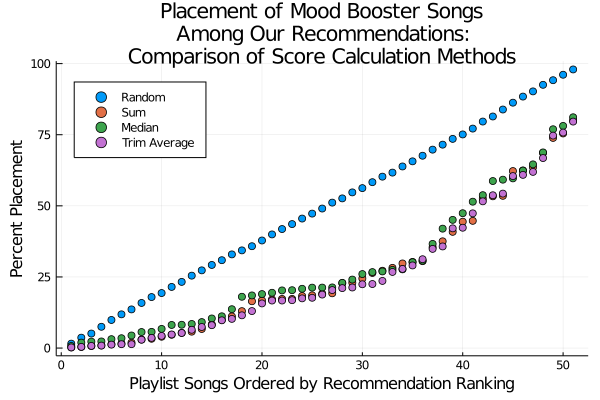

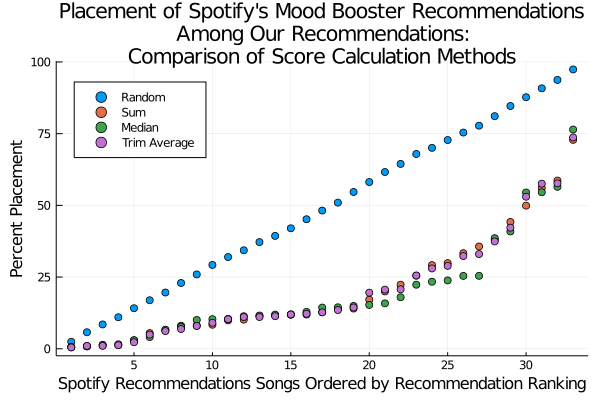

┌ Warning: Note: adding edges with a zero weight to this graph type has no effect.
└ @ SimpleWeightedGraphs /Users/shane/.julia/packages/SimpleWeightedGraphs/IDzOp/src/simpleweightedgraph.jl:105


In [24]:
# Mood Booster Playlist Testing
println("Mood Booster Testing")
println("Running Score Methods Comparison")
tester_Scores(allData, moodBoosterIds, columnsList; yearMin=2015, recList=moodBoosterRecIds, playlistTitle="Mood Booster");

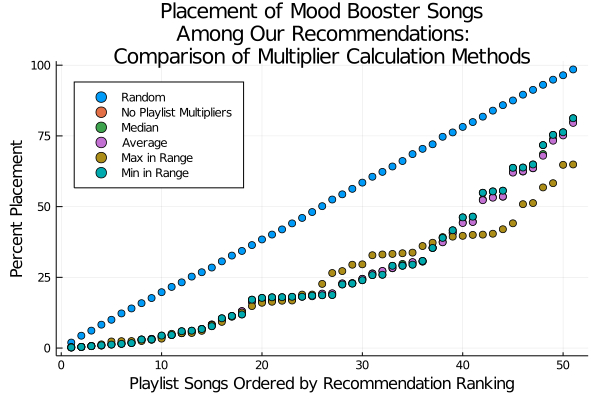

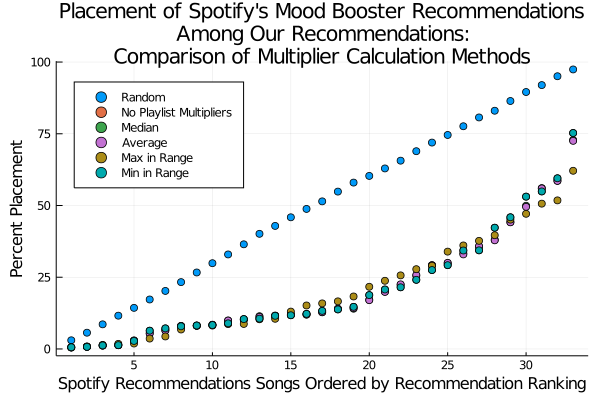

Running Multiplier Methods Comparison


In [25]:
println("Running Multiplier Methods Comparison")
tester_Multipliers(allData, moodBoosterIds, columnsList; yearMin=2015, print=false, recList=moodBoosterRecIds, playlistTitle="Mood Booster");

In [26]:
println("Getting Recommendations for Mood Booster")
getPlaylistRecommendations(allData, moodBoosterIds, columnsList; yearMin=2018, yearMax=2020, count=10, print=false)

Getting Recommendations for Mood Booster
#####################    Recommendations    #####################
Artist:   ['Moon Taxi']
Song:     Two High
Year:     2018
Id:       5huOzlgCK7PsMSG4TFBvKY
-----------------------------------------------------------------
Artist:   ['Selena Gomez']
Song:     Back To You
Year:     2018
Id:       514rhnksEwHUh6LxXsQ4Y9
-----------------------------------------------------------------
Artist:   ['Carly Pearce']
Song:     Closer To You
Year:     2020
Id:       6biq5BjD7UAXpefEgDVbp5
-----------------------------------------------------------------
Artist:   ['Selena Gomez']
Song:     Back To You - From 13 Reasons Why – Season 2 Soundtrack
Year:     2018
Id:       4hQ6UGyWQIGJmHSo0J88JW
-----------------------------------------------------------------
Artist:   ['Marshmello', 'Halsey', 'Surf Mesa']
Song:     Be Kind (with Halsey) [Surf Mesa Remix]
Year:     2020
Id:       3QNG9RhD93ypeMp3DUmkaO
-------------------------------------------------------

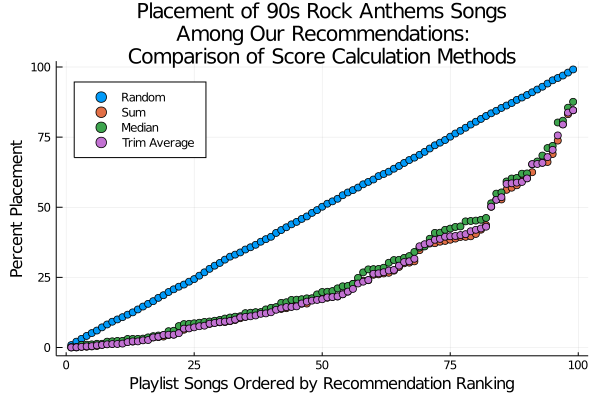

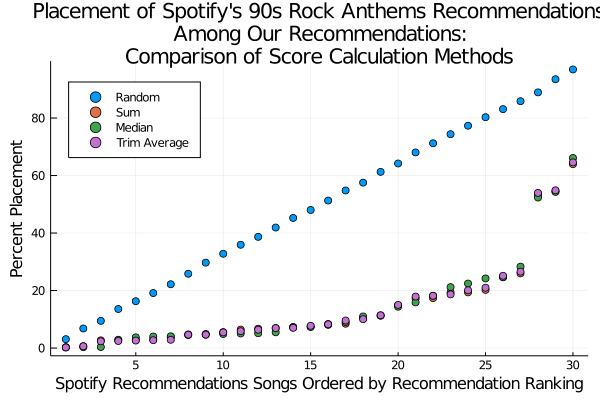

90's Rock Anthems Testing
Running Score Methods Comparison


In [27]:
# 90's Rock Anthems Playlist Testing
println("90's Rock Anthems Testing")
println("Running Score Methods Comparison")
tester_Scores(allData, rockAnthemsIds, columnsList; yearMin=1991, yearMax=1996, recList=rockAnthemsRecIds, playlistTitle="90s Rock Anthems");

In [28]:
println("Running Multiplier Methods Comparison")
tester_Multipliers(allData, rockAnthemsIds, columnsList; yearMin=1991, yearMax=1996, print=false, recList=rockAnthemsRecIds, playlistTitle="90s Rock Anthems");

In [ ]:
println("Getting Recommendations for 90's Rock Anthems")
getPlaylistRecommendations(allData, rockAnthemsIds, columnsList; yearMin=1991, yearMax=1996, count=10, print=false)

In [ ]:
# Classical Essentials Playlist Testing
println("Classical Essentials Testing")
println("Running Score Methods Comparison")
tester_Scores(allData, classicalEssentialsIds, columnsList; yearMin=1998, yearMax=2003, recList=classicalEssentialsRecIds, playlistTitle="Classical Essentials");

#####################    Recommendations    #####################
Artist:   ['Ozzy Osbourne']
Song:     I Don't Want to Change the World
Year:     1991
Id:       4dwRny1mJtE5GYuASzQSUf
-----------------------------------------------------------------
Artist:   ['The Wallflowers']
Song:     Bleeders
Year:     1996
Id:       5YpfWP8V2eULfSCMTjsZLj
-----------------------------------------------------------------
Artist:   ['Nirvana']
Song:     Come As You Are
Year:     1991
Id:       6N0ZAWkJUWUI0QYG2VwHmL
-----------------------------------------------------------------
Artist:   ['Matchbox Twenty']
Song:     Long Day
Year:     1996
Id:       4r7im8h2DTRPvl25YfNyIT
-----------------------------------------------------------------
Artist:   ['Ozzy Osbourne']
Song:     Thunder Underground
Year:     1995
Id:       6pIE1VctU7rm98HDuRl25x
-----------------------------------------------------------------
Artist:   ['Nirvana']
Song:     Come As You Are
Year:     1991
Id:       7aCSKL5LmVhakVs0

In [ ]:
println("Running Multiplier Methods Comparison")
tester_Multipliers(allData, classicalEssentialsIds, columnsList; yearMin=1998, yearMax=2003, print=false, recList=classicalEssentialsRecIds, playlistTitle="Classical Essentials");

In [ ]:
println("Getting Recommendations for Classical Essentials")
getPlaylistRecommendations(allData, classicalEssentialsIds, columnsList; yearMin=1998, yearMax=2003, count=10, print=false)

In [ ]:
# Teen Beats Playlist Testing
println("Teen Beats Testing")
println("Running Score Methods Comparison")
tester_Scores(allData, teenBeatsIds, columnsList; yearMin=2015, recList=teenBeatsRecIds, playlistTitle="Teen Beats");

In [ ]:
println("Running Multiplier Methods Comparison")
tester_Multipliers(allData, teenBeatsIds, columnsList; yearMin=2015, print=false, recList=teenBeatsRecIds, playlistTitle="Teen Beats");

In [ ]:
println("Getting Recommendations for Teen Beats")
getPlaylistRecommendations(allData, teenBeatsIds, columnsList; yearMin=2015, yearMax=2020, count=10, print=false)

In [ ]:
 printSong(allData, "electric feel")

############################################
Artist: ['MGMT']
Song:   Electric Feel
Year:   2007
Id:     3FtYbEfBqAlGO46NUDQSAt
Index:  86642
############################################
############################################
Artist: ['MGMT', 'Justice']
Song:   Electric Feel - Justice Remix
Year:   2008
Id:     2eGHyarZyRvUgFI4d3G8GN
Index:  143029
############################################


In [ ]:
test = [
    ("firework", "katy perry")
]
testID = getPlaylist(allData, test)

new = [
    "4YGOaSgYTpAkXT6NGQWGoN",
    "1kSWrMDt439cT64WpjJigW",
    "0q6LuUqGLUiCPP1cbdwFs3"
]

LoadError: UndefVarError: getPlaylist not defined

In [ ]:
testID

2-element Array{Any,1}:
 "4lCv7b86sLynZbXhfScfm2"
 "6F5c58TMEs1byxUstkzVeM"

In [ ]:
getPlaylistRecommendations(allData, testID, columnsList; yearMin=1990, yearMax=2020, count=20, print=true)

#####################       Playlist        #####################
Song:   Firework
Artist: ['Katy Perry']
Index:  33143
   acousticness: 0.139
   danceability: 0.638
   energy: 0.826
   instrumentalness: 0.0
   liveness: 0.0803
   loudness: -4.968
   speechiness: 0.0479
   tempo: 124.072
   valence: 0.649
-----------------------------------------------------------------
Song:   Roar
Artist: ['Katy Perry']
Index:  33229
   acousticness: 0.00487
   danceability: 0.5539999999999999
   energy: 0.772
   instrumentalness: 6.6e-6
   liveness: 0.354
   loudness: -4.8210000000000015
   speechiness: 0.0418
   tempo: 179.984
   valence: 0.455
-----------------------------------------------------------------
#####################    Values Ranges      #####################
   acousticness: 0.996
   danceability: 0.986
   energy: 1.0
   instrumentalness: 1.0
   liveness: 1.0
   loudness: 61.342
   speechiness: 0.955
   tempo: 244.091
   valence: 1.0
#####################     Mulitpliers      ######